## Probability problem: Pretend Poisson Processes

I was once asked an interesting probability problem which I feel is a great example of many different skills useful in data science. Of the many skills necessary for this problem, I feel the most interesting one is the fact that it masquerades as a Poisson process question. In actual fact a little critical thinking will reveal that this problem can be greatly simplified by modelling it as something completely different!  

Other useful skills covered are different probability distributions, converting from PDFs to CDFs, Bayes rule, Monte Carlo methods, empirical distributions, QQ plots...

### Question


<img src="img\BurglarBill.png" style="float: right;" width="70" height="100"></img>
Cars pass your house at night at a rate of $\lambda$ per hour. One night at midnight your young daughter still hasn't fallen asleep, so you ask her to look out her bedroom window and count different types of vehicle going by (there are no sheep locally). Thankfully she falls asleep after exactly one hour, and in the morning tells you she counted 20 cars over that hour, and number 19 was a Ferrari! She also tells you about the funny man she noticed, in a mask and striped T-shirt, climbing out the window of your neighbours house, with a sack marked "SWAG" over his shoulder. "I wouldn't have seen him in the dark", she says, "but the Ferrari arrived just as he climbed out, and the headlights lit it all up".  


<img src="img\OfficerDibble.png" style="float: right;" width="70" height="100"></img> 
Later that day Officer Dogberry knocks on your door. It turns out the neighbour was burgled on his watch (it seems he had fallen asleep) and he wants to establish a time of the crime.  

"Excellent!", he says after hearing what you have to say. "I'll report the time of crime as being between midnight and 1am then!"  

<br>
<img src="img\evil lawyer.jpg" style="float: right;" width="70" height="100"></img>  
Some days later Mr Bill Tulkinghorn, the local prosecutor, picks up the case and rings you for more details. "Bet you £100 it was old Tom Robinson!" he chuckles. "Alibis are like hearts - half a heart, you're still dead!"   

It turns out that Tom Robinson has an alibi only for part of the period: CCTV confirms he was in the local Tesco's from 12.45 onwards. "So he did it in the first half hour!" retorts a conviction-hungry Tulkinghorn, "don't you get in the way of my promotion!".   

<img src="img\happy judge c.jpg" style="float: right;"  width="70" height="100"></img>  
As a data science student, you try to explain about different probability distributions, and that a uniform distribution might not capture all the information given. You get the feeling he isn't really that interested, so decide you must use your skills to pursuade the judge and get to Justice!  

Modelling car arrivals as a Poisson process, find the distribution for the time the burglar exited the neighbour's house.

### Function for plotting distributions

Before you start solving the problem, you whip up a function which will plot any probability distribution you throw at it:

In [210]:
n_total_num_vehicles    = 20
k_ferrari               = 19
a_start_time            = 0
b_end_time              = 1
alibi_times             = [0.75, 1]             # start and end times of alibi

assert k_ferrari <= n_total_num_vehicles
assert a_start_time < b_end_time
for time in alibi_times:
    assert ((time >= a_start_time) and (time <=b_end_time)) 

In [211]:
import numpy as np
import matplotlib.pyplot as plt


# make a list of basic colours which can be cycled through
colours_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_multiple_PDFs_CDFs(list_PDFs, support_subset=[a_start_time, b_end_time], display_or_return_ax='display', axes=None):
    '''Plots PDFs and CDFs for all provided distributions on two axes over the specified support.
    
    Args:
        list_PDFs       :       a list of functions. Each function in the list represents a different PDF.
                                The final item in the list is the "best" one, the others are only shown to contrast to it
                                So the final item is shown with an unbroken line, as opposed to all other items.
                                Each function (for each distribution) returns the following:
                                    'name'      :   the name of the PDF, for the legend.
                                    'frozen_RV' :   the scipy frozen RV for the distribution.
                                                        If not None, this is plotted, just to check - should overlap with plot of my_func.
                                    'my_func'   :    a function which describes the distribution by 
                                                        returning its PDF and CDF when given x.
        support_subset  :       the part of the support of the distribution to show.
                                For example, if the PDF is the standard normal (whose support is all real numbers),
                                this could be given as [-3, 3] so that the plot will cover that range.
        display_or_return_ax:   specifies whether the plot should be displayed, or returned (e.g. for modification)
        axes            :       the axes to plot on (a tuple - one ax for pdf and one for cdf), if provided
                                If not provided, creates new.

    Returns:
        ax              :       if display_or_return_ax=='return', it returns the axes for pdf and cdf.
                                Otherwise this function plots the axes and returns None.
    '''

    x = np.linspace(start=support_subset[0],stop=support_subset[1], num=500+1)
    x = np.hstack([[x[0] - 10**-10],    x,    [x[-1] + 10**-10]   ])

    #either create new axes, or use supplied axes
    if axes==None:
        fig, (ax_pdf, ax_cdf) = plt.subplots(1,2, figsize=(15,6))
    else:
        (ax_pdf, ax_cdf) = axes

    for i, (name, scipy_frozen_RV, distribution_func) in enumerate(list_PDFs):
        # choose a unique colour for the PDF and CDF for this item
        colour = colours_cycle[i%len(colours_cycle)] 

        label = label='('+str(i+1)+') ' + name

        if scipy_frozen_RV is not None:
            scipy_pdf = scipy_frozen_RV.pdf(x)
            ax_pdf.plot(x, scipy_pdf, #label=dist_name, linestyle=':',
                  lw=8,  c=colour, alpha=.25)  

            scipy_cdf = scipy_frozen_RV.cdf(x)
            ax_cdf.plot(x, scipy_cdf, #label=dist_name, linestyle=':', 
                lw=8, c=colour, alpha=.25 )  

        distribution_func_pdf, distribution_func_cdf = distribution_func(x)
        ax_pdf.plot(x, distribution_func_pdf, label=label, c=colour,
            linestyle=('-' if i==len(list_PDFs)-1 else '--') , alpha=.8, )
        ax_cdf.plot(x, distribution_func_cdf, label=label.replace('$f_', '$F_'), c=colour,
            linestyle=('-' if i==len(list_PDFs)-1 else '--') , alpha=.8, )


        # plt.plot(y_2, f_y2_N3, c='orange', label='posterior')

    ax_pdf.set_xlabel('time of arrival')
    ax_pdf.set_ylabel('probability density')
    ax_pdf.set_title('PDFs')         #  $f_{Y_2 | N} (y_2 | N=3)$

    ax_cdf.set_xlabel('time of arrival')
    ax_cdf.set_ylabel('cumulative probability')
    ax_cdf.set_title('CDFs')
    ax_cdf.set_ylim(-.05, 1.05)

    ax_pdf.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),)
    ax_cdf.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),)

    if display_or_return_ax=='display':
        plt.show()
    elif display_or_return_ax=='return':
        return (ax_pdf, ax_cdf)


### First thoughts: Dogberry's approach

Before jumping into the answer, it is important to always discuss wrong approaches first. From a pedagogical point of view, jumping straight to the correct answer only teaches the answer to this particular problem, whereas discussing this fully helps develop critical thinking, which once acquired can then be transferred to other problems.  


In [212]:
import scipy.stats
import scipy.special

RV_symbol = 'X_{' + str(k_ferrari) + '}'

def uniform(a, b, RV_symbol=RV_symbol):
    def uniform_a_b(x):
        pdf = np.ones_like(x) / (b-a)
        pdf[(x<a) | (x > b)] = 0
        cdf = (x-a) / (b-a)
        cdf[(x<a)] = 0
        cdf[(x>b)] = 1
        return pdf, cdf

    name = (r'$f_{'+RV_symbol+'}(x) \ \mathrm{where} \ '
                + RV_symbol +' \sim  \mathrm{Uniform}(['+str(a)+','+str(b)+'])$')

    scipy_frozen_RV = scipy.stats.uniform(a, b)

    return name, scipy_frozen_RV, uniform_a_b


In [213]:
def probability_outside_alibi(distribution_func, alibi_times):
    CDF_evaluated_at_alibi_times = distribution_func[-1](np.array(alibi_times))[1]
    probability_inside_alibi = CDF_evaluated_at_alibi_times[1] - CDF_evaluated_at_alibi_times[0]
    return 1 - probability_inside_alibi

probability_outside_alibi(distribution_func=uniform(a_start_time, b_end_time), alibi_times=alibi_times)

0.75

<img src="img\OfficerDibble.png" style="float: right;" width="70" height="100"></img> 
Officer Dogberry's uniform model would mean there is a 75% chance the robbery happened before the alibi, making the alibi worthless.   

However as we know that it was the 19th of 20 arrivals, the distribution is clearly not uniform — so it is his model which is worthless.  

### Second thoughts: Tulkinghorn's calculation  

<img src="img\evil lawyer.jpg" style="float: right;" width="70" height="100"></img>  
Tulkinghorn is pretty annoyed you've ruled out Dogberry's model, so he googles up on probability distributions and finds out about Poisson processes and MLE. 

#### Erlang distribution
At first thought, this may seem to be modelled best by the [Erlang distribution](https://en.wikipedia.org/wiki/Erlang_distribution). The Erlang distribution is an extension of the [Exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), in that the exponential distribution models "time until first arrival of a Poisson process", whereas the Erlang distribution allows you to specify the $k$'th arrival, so it models "time until  $k$'th arrival of a Poisson process":

$$f_{Y_k} (y) 
= \cfrac{\lambda^k y^{k-1}   \mathrm{e}^{-\lambda y}}  {(k-1)!}   
 $$

So the Erlang distribution is really just the distribution of a sum of $k$ Exponential Random Variables. Also, note that if we set $k=1$, the Erlang distribution is the time until the first arrival, or the distribution of a sum of $1$ Exponential Random Variable - so it unsurprisingly simplifies to the Exponential distribution:

$$f_{Y_1} (y) 
= \cfrac{\lambda^k y^{k-1}   \mathrm{e}^{-\lambda y}}  {(k-1)!}   
= \cfrac{\lambda^1  y^0 \mathrm{e}^{-\lambda y}}  {1}   
= \lambda  \mathrm{e}^{-\lambda y}
\ \ \ \ \ \ \ \ \text{(because by definition } 0!=1 \text{)}
 $$


#### Estimating $\lambda$  

<img src="img\evil lawyer.jpg" style="float: right;" width="70" height="100"></img>  
Tulkinghorn presents his estimate for $\lambda$:  
$$\hat{\lambda}_{\text{mle}} 
 = \frac{n}{\sum_{i=1}^n T_i}
 = \frac{n}{Y_1 + \sum_{i=2}^n Y_i-Y_{i-1}}
 = \frac{n}{Y_n }
 = \frac{\text{number of arrivals}}{\text{time period in which all arrivals happen}}$$

where $Y_i$ is the time from the start until the $i$'th arrival, and $T_i$ is the inter-arrival time between arrivals $i-1$ and $i$.  

He calculates this as follows:


In [214]:
lambda_MLE = n_total_num_vehicles / (b_end_time-a_start_time)
print('lambda_MLE =', lambda_MLE)

lambda_MLE = 20.0


(food for thought: is the calculation accurate?)

#### Applying the Erlang distribution
Applying the Erlang distribution here, using parameter $\lambda=\hat{\lambda}_{\text{mle}} $, and $k=19$ (for the 19th arrival), gives us:  
$$f_{X_{19}} (x) 
= \cfrac{\hat{\lambda}_{\text{mle}} ^k x^{k-1}   \mathrm{e}^{-\hat{\lambda}_{\text{mle}}  x}}  {(k-1)!}   
= \cfrac{ 20^{19} \ x^{18}  \  e^{-20 x}}  {18!}  
 $$

where $X$ is an RV representing times of arrivals from a Poisson process, with parameter rate $\lambda=\hat{\lambda}_{\text{mle}}$. $X_1$ is the time of the first arrival, $X_2$ is the time of the second arrival from the beginning of the period, etc. 


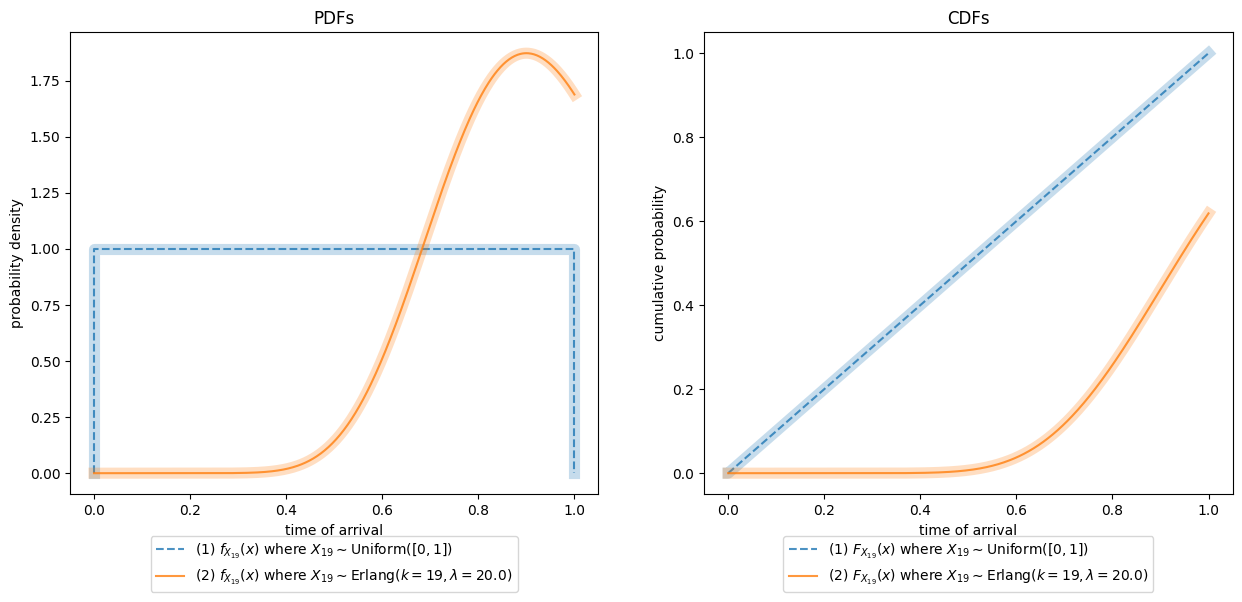

In [215]:

def erlang(Lambda, k, RV_symbol=RV_symbol):
    def erlang_Lambda_k(x):
        pdf = Lambda**k  *  x**(k-1)  *  np.exp(-Lambda*x)  /  scipy.special.factorial(k-1)
        cdf = scipy.special.gammainc(k, Lambda*x) #/ scipy.special.factorial(k-1)
        # print(scipy.special.gammainc(k, Lambda*x))
        # print(scipy.special.factorial(k-1))
        # print(cdf)
        return pdf, cdf

    name = (r'$f_{'+RV_symbol+'}(x) \ \mathrm{where} \ '
                + RV_symbol +' \sim  \mathrm{Erlang}(k='+str(k)+', \lambda='+str(Lambda)+')$')

    scipy_frozen_RV = scipy.stats.erlang(a=k, loc=a_start_time, scale=1/Lambda)
                        #scipy parameterises the erlang dist using a=k, scale=1/lambda

    return name, scipy_frozen_RV, erlang_Lambda_k


list_PDFs = [   uniform(a=a_start_time, b=b_end_time),
                erlang(Lambda=lambda_MLE, k=k_ferrari)]

_ = plot_multiple_PDFs_CDFs(list_PDFs, support_subset=[a_start_time, b_end_time], )

#### Why that isn't correct

The above is obviously wrong because it allows for the arrival to come after the end of the hour, when we know for a fact that it came within the hour.
This can be seen clearly on the CDF graph, where at time=1 the CDF is less than 1, meaning there is a chance of the arrival being later. Calculating this exactly:

In [216]:
name, scipy_frozen_RV, distribution_func = erlang(Lambda=lambda_MLE, k=k_ferrari)

print('The above model believes the arrival can happen after the end of the time period, with probability', 
 1-distribution_func(b_end_time)[1],  1-scipy_frozen_RV.cdf(b_end_time),
    1-scipy.stats.erlang(a=k_ferrari, loc=a_start_time, scale=1/lambda_MLE).cdf(b_end_time))

The above model believes the arrival can happen after the end of the time period, with probability 0.38142194944715513 0.38142194944715513 0.38142194944715513


### Tulkinghorn's second attempt: truncated Erlang distribution

The above problem can be simply solved by using conditional probability: we need the distribution of the second arrival, conditioned on the fact that it happened before the end of the hour.

$$\begin{align*}
f_{X_{19}} (x | X_{19} \leq 1) 
& = \cfrac{f_{X_{19}} (x , X_{19} \leq 1) }   {P(X_{19}\leq1)}
= \cfrac{f_{X_{19}} (x ) }   {F_{X_{19}}(1)} \text{  for } x\leq1  , 0 \text{ otherwise.}
\\
& = \cfrac { \left( \cfrac{\lambda^k x^{k-1}   \mathrm{e}^{-\lambda x}}  {(k-1)!}  \right) }
            {\left( \cfrac{\gamma (k, \lambda x)}  {(k-1)!} \right)}
= \cfrac {\lambda^k x^{k-1}   \mathrm{e}^{-\lambda x}}  
            { \gamma (k, \lambda x)}  
 \text{  for } x\leq1  , 0 \text{ otherwise.}
 \end{align*}$$

(In a nutshell, we simply divide both the CDF and PDF by $F_{X_{19}}(1) = \text{P}(X_{19} \leq 1)$, and restrict this to $x \leq 1$, as elsewhere it has probability $0$).

In [217]:
class trunc_erlang_gen(scipy.stats.rv_continuous):
    '''Creates a custom RV within the scipy framework - 
    see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html
    This RV is a truncated Erlang distribution, and modifies the pdf, cdf and ppf of the Erlang distribution accordingly'''

    def _get_support(self, Lambda, k, truncation):   
        return 0, truncation

    def _pdf(self, x, Lambda, k, truncation):
        non_truncated_erlang = scipy.stats.erlang(scale=1/Lambda, a=k)
        return np.where(
            x<truncation,
            non_truncated_erlang.pdf(x=x) / non_truncated_erlang.cdf(truncation),
            0    )

    def _cdf(self, x, Lambda, k, truncation):
        non_truncated_erlang = scipy.stats.erlang(scale=1/Lambda, a=k)
        return np.where(
            x<truncation,
            non_truncated_erlang.cdf(x=x) / non_truncated_erlang.cdf(truncation),
            1  )

    def _ppf(self, pp, Lambda, k, truncation):
        non_truncated_erlang = scipy.stats.erlang(scale=1/Lambda, a=k)
        # print(pp)
        pp_adjusted = pp * non_truncated_erlang.cdf(truncation)             #e.g. the 25th quantile of a trunced dist which only has 80% of the non-trunced dist, 
                                                                            #  is the 20th  quantile of non-trunced dist.
        # print('*',non_truncated_erlang.cdf(truncation), pp_adjusted)
        # print('*',non_truncated_erlang.ppf(pp_adjusted))
        return np.minimum(truncation, non_truncated_erlang.ppf(pp_adjusted))

trunc_erlang = trunc_erlang_gen(name='trunc_erlang')

print(np.arange(-.2,2,.2))
print(trunc_erlang(Lambda=2, k=2, truncation=1.5).cdf(x=np.arange(-.2,2,.2)))
print()
print(np.arange(0.0,1.01,.1))
print(trunc_erlang(Lambda=2, k=2, truncation=0.50).ppf(np.arange(0.0,1.01,.1)))

[-0.2  0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8]
[0.         0.         0.07685809 0.23875564 0.42126741 0.59320476
 0.74170303 0.86352933 0.96012999 1.         1.        ]

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.         0.12480752 0.18334069 0.23162653 0.27495061 0.3153653
 0.35393419 0.39130209 0.42790316 0.46405381 0.5       ]


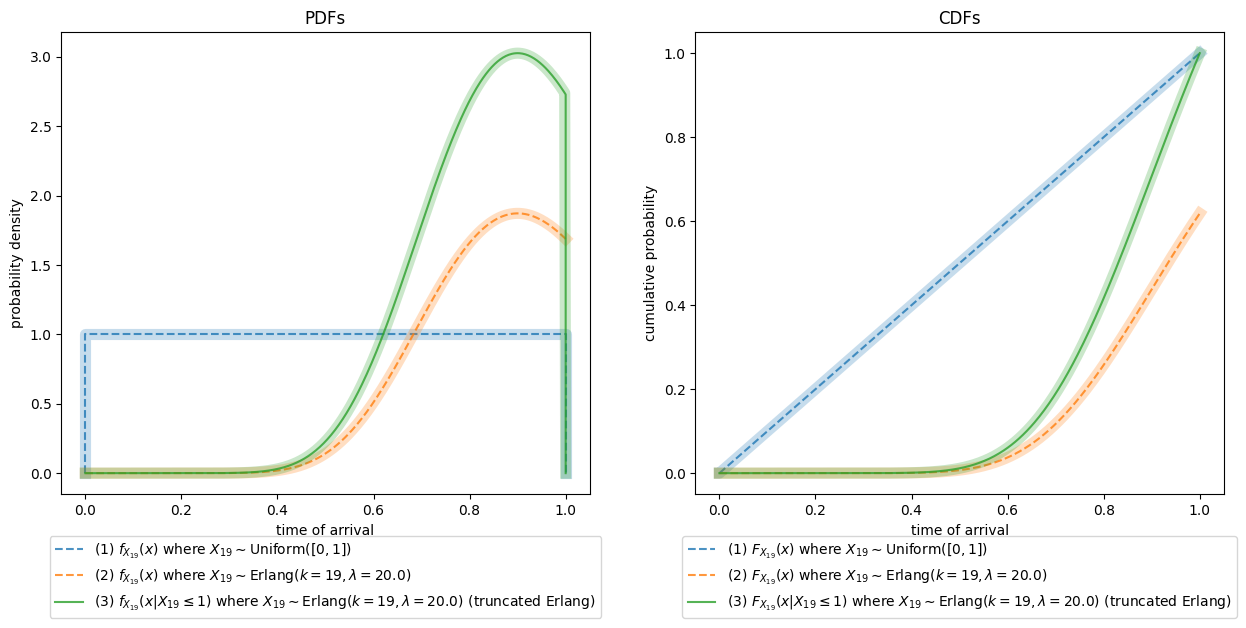

In [221]:
def erlang_given_latest_time(Lambda, k, latest_time, RV_symbol=RV_symbol):

    def erlang_Lambda_k_latest_time(x):

        prob_before_latest_time = scipy.special.gammainc(k, Lambda*latest_time) 
        # scipy.special.gammainc is the *Regularized* lower incomplete gamma function, which gives the CDF of the erlang
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html
        # print(prob_before_latest_time)

        pdf = Lambda**k  *  x**(k-1)  *  np.exp(-Lambda*x) / prob_before_latest_time  /  scipy.special.factorial(k-1)
        cdf = scipy.special.gammainc(k, Lambda*x) / prob_before_latest_time

        pdf[(x<0) | (x>latest_time)] = 0
        cdf[x>latest_time] = 1

        return pdf, cdf

    name = (r'$f_{'+RV_symbol+'}(x | '+RV_symbol+' \leq '+str(latest_time)+') \ \mathrm{where} \ '
            +RV_symbol+' \sim  \mathrm{Erlang}(k='+str(k)+', \lambda='+str(Lambda)+')$ (truncated Erlang)')

    scipy_frozen_RV = trunc_erlang(Lambda=Lambda, k=k, truncation=latest_time) # trunc_erlang(a=k, loc=a_start_time, scale=1/Lambda, latest_time=latest_time)#None

    return name, scipy_frozen_RV, erlang_Lambda_k_latest_time


list_PDFs.append(   erlang_given_latest_time(Lambda=lambda_MLE, k=k_ferrari, latest_time=b_end_time)  )

_ = plot_multiple_PDFs_CDFs(list_PDFs, support_subset=[a_start_time, b_end_time], )

This is better because now $F_{X_{19}}(x \leq 1) = 1$, as can be seen in the new CDF above, and as calculated below :

In [222]:
name, scipy_frozen_RV, distribution_func = erlang_given_latest_time(Lambda=lambda_MLE, k=k_ferrari, latest_time=1)

print('The above model believes the arrival can happen after the end of the time period, with probability', 
 1-distribution_func(np.array([b_end_time]))[1][0],  1-scipy_frozen_RV.cdf(b_end_time),
    1-trunc_erlang(Lambda=lambda_MLE, k=k_ferrari, truncation=b_end_time ).cdf(b_end_time))

The above model believes the arrival can happen after the end of the time period, with probability 0.0 0.0 0.0


In [223]:
probability_outside_alibi(distribution_func=erlang_given_latest_time(Lambda=lambda_MLE, k=k_ferrari, latest_time=1), 
                    alibi_times=alibi_times) 

0.29184399318070386

<img src="img\evil lawyer.jpg" style="float: right;" width="70" height="100"></img>  
"So, your Honour!!!", roars Tulkinghorn, "this so-called alibi is worthless! It is purrr-fectly possible that the accused committed the crime prior to this miserable alibi!!! I rest my case!"

#### Why Tulkinghorn is still wrong  

Well for starters, the MLE isn't perfect. It is true that $\hat{\lambda}_{\text{mle}}  = \frac{n}{Y_n }$, however we don't know the exact time of the final arrival. Instead Tulkinghorn used the end of the period to approximate time of the final arrival. So $\hat{\lambda}_{\text{mle}}$ should be slightly higher.  


However, the truth is that **the Erlang distribution just isn't the right distribution** at all for this problem.  
The question suggested to model it as a Poisson Process — but that is misleading! It could have just said that the arrivals are independent.    

The truth is that *a Poisson / Exponential / Erlang model is appropriate only if the number of arrivals over the period is unknown*. Why is that?  

##### Intuitive explanation

To understand this intuitively, consider the following. A Poisson Process can tell you how long in the future something will happen, but also, looking backwards from a particular point in time, it can tell you how long ago something happened. Using the cars example, the number of cars in the next hour is Poisson; and the number of cars over the last hour until now is also Poisson. Similarly, the length of time until the next car is Exponential; and the length of time *since* the previous car is also Exponential. So if you start watching cars at a certain time, you can say that the length of time till the next car arrives is exponentially distributed; and that the length of time elapsed since the previous car arrived is also exponentially distributed.  

Now, imagine exactly one car comes between 12 and 1 and we don't know when. We can look at it from both directions, because we know it is the first going forwards from 12, and also the first going backwards from 1!  
Taking $\lambda=5$, that means $\text{E}[X]=1/\lambda = 1/5$. So looking at it from the start, we expect the car to come after 12 minutes. But if we look at it from the end of the hour, then we will expect it to come 12 minutes before the end of the hour!  

If we think about the probability distribution (instead of just the expected value) for  $\lambda=5$, the arrival time is "pulled" to the beginning of the hour if we look forwards from the start; but the arrival time is "pulled" to the *end* of the hour if we look backwards from the end. The two "pulls" in this tug of war are symmetric over the centre of the period, and so they both cancel out. So the truth in this case of just one car is that its arrival is **uniformly distributed** across the interval.   

##### Graphical demonstration

The following graphs illustrate this:


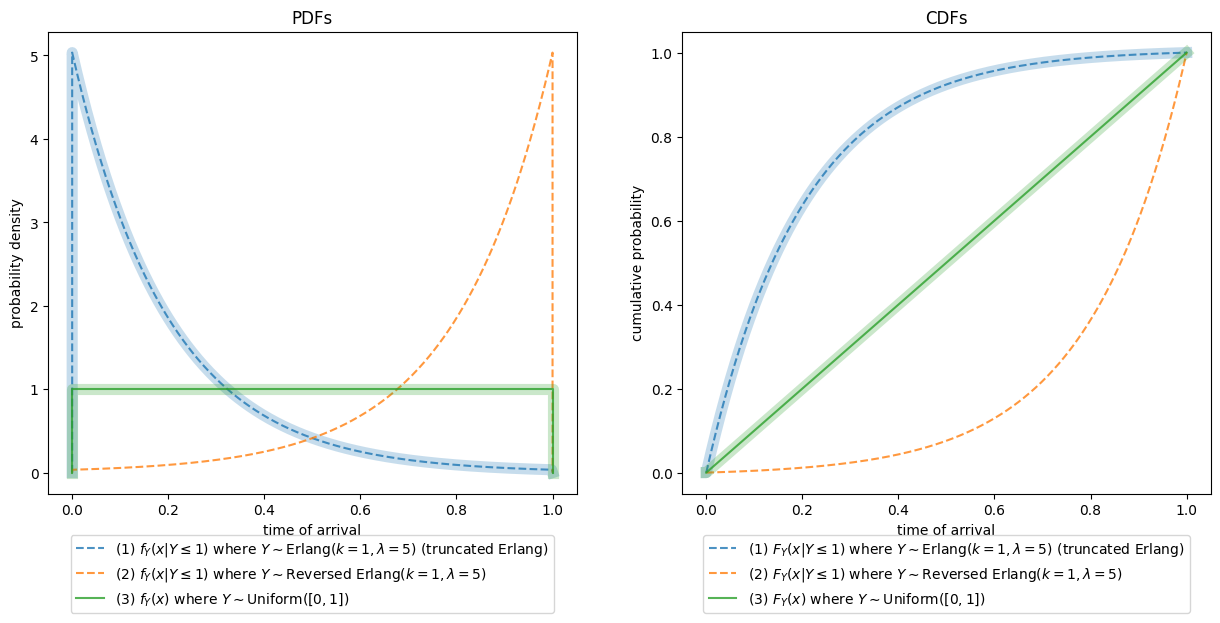

In [224]:
def reversed_erlang_given_earliest_time(Lambda, k, earliest_time, RV_symbol=RV_symbol):
    ''''earliest_time means how much earlier from current time it can be.
    So if you know the arrival was in the last hour, earliest_time=1.'''
    erlang_Lambda_k_latest_time_func = erlang_given_latest_time(Lambda, k=k, latest_time=earliest_time)[-1]
    def reversed_erlang_Lambda_k_latest_time(x):
        forwards_pdf, forwards_cdf = erlang_Lambda_k_latest_time_func(x)
        return forwards_pdf[::-1], 1-forwards_cdf[::-1]

    name = (r'$f_{'+RV_symbol+'}(x | '+RV_symbol+' \leq '+str(earliest_time)+') \ \mathrm{where} \ '
            +RV_symbol+' \sim  \mathrm{Reversed \ Erlang}(k='+str(k)+', \lambda='+str(Lambda)+')$')

    scipy_frozen_RV = None

    return name, scipy_frozen_RV, reversed_erlang_Lambda_k_latest_time


list_PDFs_one_arrival_example = [erlang_given_latest_time(Lambda=5, k=1, latest_time=1, RV_symbol='Y'),
                                 reversed_erlang_given_earliest_time(Lambda=5, k=1, earliest_time=1, RV_symbol='Y'),
                                 uniform(a=0, b=1, RV_symbol='Y')       ]

_ = plot_multiple_PDFs_CDFs(list_PDFs_one_arrival_example, support_subset=[0,1], )

In the above graphs, the first blue line shows the correct probability distribution for the time until the first arrival, given that it happened before one hour, IF we have no knowledge of how many other arrivals there were after the first one.  

The second orange line shows the correct probability distribution for the time until the *last* arrival before the end of the hour, given that it was within the last hour, IF we have no knowledge of how many other arrivals there were before the most recent one.  

But when we know that an arrival is both the first and the last, our knowledge that it is the first "pulls" it towards the start of the period; but our knowledge that it is the last "pulls" it towards the end of the period. So in actual fact it is uniform over the period. This is shown by the green line.  



The same idea holds true for e.g. the second out of 5 arrivals - this arrival is second from the beginning and fourth from the end, and the two erlang distributions pull in opposite directions. (Here however it is clear that the correct distribution won't be Uniform - see later)

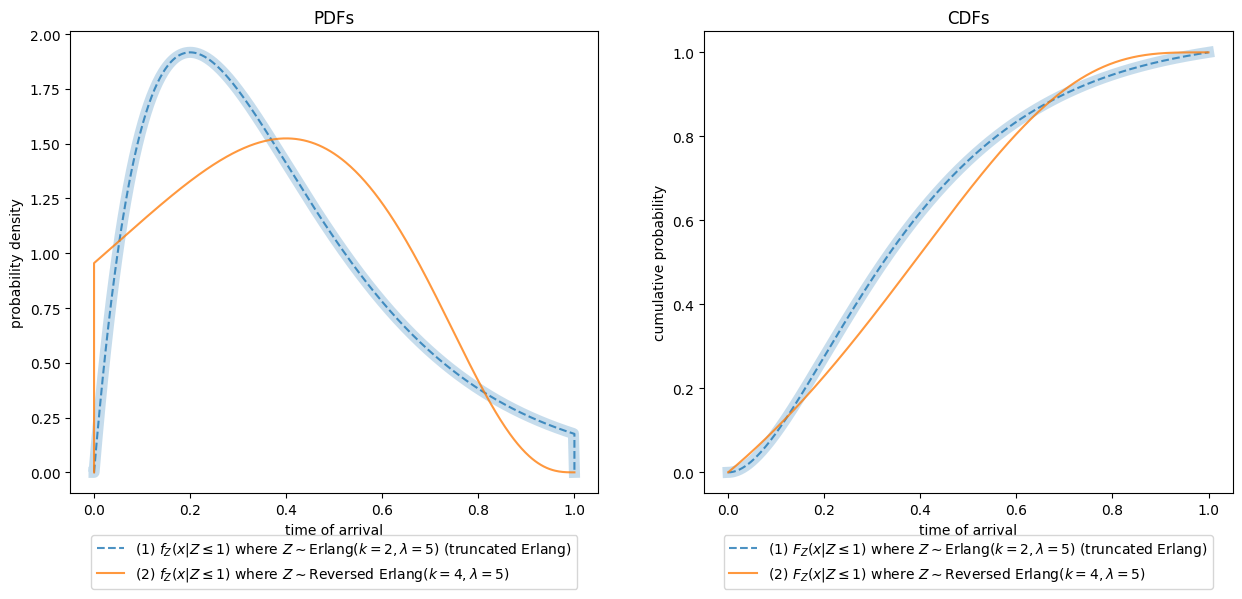

In [225]:
list_PDFs_second_arrival_example = [erlang_given_latest_time(Lambda=5, k=2, latest_time=1, RV_symbol='Z'),
                                 reversed_erlang_given_earliest_time(Lambda=5, k=4, earliest_time=1, RV_symbol='Z'),
                                     ]

_ = plot_multiple_PDFs_CDFs(list_PDFs_second_arrival_example, support_subset=[0,1], )

##### Mathematical derivation

Now that there is an intuitive understanding of the complication, we can demonstrate mathematically that the above is correct:  

$$f_X{(x)} = \lambda e^{-\lambda x} \ \ 
\text{and} \ \ F_X{(x)} = 1- e^{-\lambda x} \ \ 
\text{where} \ \ X \sim \text{Exp}(\lambda)$$  

**(1) If we know the arrival was within $t$ hours, but don't know how many arrivals there were in that period:**
$$f_X{(x \ \ | \ \ x \leq t)} 
= \cfrac {\lambda e^{-\lambda x} } {F_X(t)}
= \cfrac {\lambda e^{-\lambda x} } {1- e^{-\lambda t}}
\ \ \ \ \text{for} \ 0 \leq x \leq 1 \ , \ \ \ 0 \text{ otherwise.}
$$  


**(2) If we know the arrival was within $t$ hours, and also know there was exactly one arrival over the period of $t$ hours** - i.e. we know that the *second* arrival came only after the end of the period; alternatively, that in the section of the period after the first arrival, there were $0$ arrivals. So we need to find    
$$
f_{X}{(x \ \ | \ \  \text{one arrival within the period})} = 
f_{X}{(x \ \ | \ \  \text{first arrival within the period; \textbf{and}, no arrivals in the remaining time})} 
$$    

We can use [Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), which states that:  
$$
\text{For events:}  \ \ \
 \text{P}(A \mid B) = \frac{\text{P}(B \mid A) \, \text{P}(A)}{\text{P}(B)}. 
\ \ \ 
\text{For continuous RVs:}  \ \ \ \ 
f_{X|Y}(x \  |  \  y) = \frac{f_X(x)   \,  f_{Y|X}(y \  | \   x) }  {f_Y(y)}
$$
 Let us split this into three parts:    A $f_X(x)$, B $f_{Y|X}(y  \ | \   x)$ and C $f_Y(y)$ and proceed.



**A. Part A $f_X(x)$  :**  

This is the unconditional distribution of the time of the first arrival, which is simply given by the Exponential PDF:
$$f_X(x) = \lambda e^{-\lambda x}$$


**B. Part B $f_{Y|X}(y \  | \   x)$  :**  

In our case, $Y$ refers to two things happening: both that the first arrival was within the period, and there were no other arrivals in the period. So  
$$f_{Y|X}(y \  | \  x) = \mathbf {1}(x \leq t) \times \text{P}(\text{no further arrivals in period \ \ | \ \ first arrival happened at time }x)
$$
 We can evaluate $\text{P}(\text{no further arrivals})$ either using the CDF of the Exponential distribution, or the PMF of the Poisson distribution:
 1. using the CDF of the Exponential distribution, exploiting the [memorylessness property of the Poisson process](https://en.wikipedia.org/wiki/Memorylessness#The_memoryless_distribution_is_an_exponential_distribution):
 $$\begin{align*}
 \text{P}(\text{no further arrivals in period}) & = \text{P}(\text{next arrival is in longer than } t-x) 
 \\ & =  \text{P}(X > t-x)
 \\ & =  1-F_X(t-x)
 \\ & = 1-(1-e^{-\lambda (t-x)})
 \\ & = e^{-\lambda (t-x)}
 \end{align*}
 $$ 
 2. or using the PMF of the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) of $A$, the number of arrivals in the remaining time. We substitute $\lambda(t-x)$ for $\lambda$ in the Poisson PMF, $A \sim \text{Poiss}(\lambda(t-x))$, since the rate is proportional to interval length, and find the probability $A=0$ in that interval, i.e. no arrivals:
 $$\begin{align*}
 \text{P}(\text{no further arrivals in period}) & = \text{P}(\text{zero arrivals in remaining period of length } t-x) 
 \\ & =  \text{P}(A=0)
 \\ & =  \frac{  e^{-\lambda (t-x)}  (\lambda (t-x))^0 }  {0!}  
 \\ & = e^{-\lambda (t-x)}
 \end{align*}
 $$ 
\- so both methods produce the same result.   

So now we have 
$$f_{Y|X}(y \ | \  x) = \mathbf {1}(x \leq t) \times e^{-\lambda (t-x)}
$$



**C. Part C $f_Y(y)$  :**  

We can use parts A and B to compute part C, $f_Y(y)$, by integrating $f_{Y|X}(y \ | \  x) f_X(x)$ over all values of $x$ between $0$ and $t$. Let us first simplify $f_{Y|X}(y \ | \  x) f_X(x)$:

$$\begin{align*}
f_{Y|X}(y \ | \  x) f_X(x) & 
=  \mathbf {1}(0 \leq x \leq t) \times e^{-\lambda (t-x)} \times \lambda e^{-\lambda x} 
\\ & =   \mathbf {1}(0 \leq x \leq t) \times \lambda e^{-\lambda t + \lambda x -\lambda x} 
\\ & =    \lambda e^{-\lambda t}  \ \ \text{ for } 0 \leq x \leq t  .
 \end{align*}
$$

Now we integrate $f_{Y|X}(y \ | \  x) f_X(x)$ over all possible values of $x$ between $0$ and $t$. 

$$\begin{align*}
f_Y(y) & = \int_{0}^{t} f_{Y|X}(y \ | \  x) f_X(x) \  dx
\\ & = \int_{0}^{t} \mathbf {1}(0 \leq x \leq t) \times \lambda e^{-\lambda t} \ dx
\\ & = \mathbf {1}(0 \leq x \leq t) \times \lambda e^{-\lambda t} \times  \int_{0}^{t} 1 \ dx
\\ & = \mathbf {1}(0 \leq x \leq t) \times \lambda e^{-\lambda t} \times \big[ x \big]_{0}^{t}  
\\ & = \mathbf {1}(0 \leq x \leq t) \times \lambda e^{-\lambda t} \times t
 \end{align*}
$$

Alternatively, we can easily get the same answer by using the Poisson PDF: this part describes the probability of having $1$ arrival over a period of length $t$ when arrival rate per unit time is $\lambda$, so "rate per period length" is $\lambda t$. So  

$$\begin{align*}
f_Y(y) & = \frac{(\lambda t)^1 e^{-\lambda t} }     {1!}
\\ & = \lambda t e^{-\lambda t} 
 \end{align*}
$$  
\- the same as we got by integrating.  


**Putting this into Bayes formula**

In Part C we have already simplified the numerator and calculated the denominator. All that remains is to show that this cancels out:

$$\begin{align*}
f_{X|Y}(x \ \ | \ \  y)
   & = \frac{f_X(x)  \,  f_{Y|X}(y \ \ | \ \  x)}  {f_Y(y)}
\\ & = \mathbf {1}(0 \leq x \leq t)
         \frac{ \lambda e^{-\lambda t}}  {\lambda e^{-\lambda t} \times t}
\\ & =   \frac{ 1}  {t} \ \text{ for } 0 \leq x \leq t \ \ .
 \end{align*}
$$

\- which is of course the uniform distribution.

**Conclusion**  

The above shows that as discussed, when there is only one Poisson process arrival over an interval, the distribution of the time of that arrival is not exponential, but is uniform over the period.

### The truth will out: the data scientist approach

After the second attempt (Tulkinghorn's), we discussed that the Erlang distribution isn't the right distribution for this problem, and the mention of Poisson Process in the question is misleading — because when the number of arrivals over the period is known, arrivals are distributed uniformly over the period.  

Now we can return to the original question, in which there were $n=20$ arrivals over an hour, and we want the probability distribution of the $k=19$'th arrival. We now know that the time of each arrival is uniformly distributed over the hour, so we can find the distribution of the $k=19$'th using [$k$'th order statistics](https://en.wikipedia.org/wiki/Order_statistic).  

Let us work this out generally, for the case of $k$ arrivals before time $x$, out of a total of $n$ arrivals which occurred in the interval $[a,b]$. We will then be able to apply that to this case.

Before jumping into the maths, it often helps a lot to try to reformulate the question in terms of known distributions. We thereby reduce the problem to one for which the answer is clear. As we will see, it can be possible to reformulate the problem in different ways, some of which are more helpful than others.   

#### Method #1: CDF as Binomial distribution

Let us start with the CDF of this distribution: the cumulative probability that $k$ arrivals out of $n$ have happened before time $x$. Rephrasing, this considers the time by which $X_k$ happens, where $X_k$ is the $k$'th arrival after sorting them in order of arrival time. Rephrasing again, this means the probability that $k$ or more arrivals have happened before time $x$.  

This type of rephrasing is often very helpful with problems like this. Using that reformulation, we have recast the problem, from an order statistics problem, to a simple Bernoulli / Binomial distribution!   

We can introduce the new RV $B_k$ which indicates whether $X_k$ happened before $x$, so $B_k = \textbf{1}(X_k \leq x)$. So $B_k \sim \text{Bernoulli}(\text{P}(X_k \leq x))$. As we have previously shown that *individual* arrivals are uniform, i.e. $X \sim \text{Uniform}([a,b])$, we can say that $\text{P}(X \leq x) = \frac{x-a}{b-a}$, from the CDF of the Uniform.  

The sum of Bernoulli RVs is described by the Binomial distribution. Let us denote by $K$ the number of arrivals before time $x$, out of $n$ total arrivals over the period. So $K = \sum_{k=1}^n B_k = \sum_{k=1}^n \textbf{1}(X_k \leq x)$. Then we consider each arrival as a trial, with success being arrival before time $x$, where probability of success has already been found. So $K \sim \text{Bin}(n, \ \frac{x-a}{b-a})$: The number of arrivals before $x$ is a binomial distribution with parameters $n$ and $\frac{x-a}{b-a}$.  

So we can say that 

$$\begin{align*}
F_{X_k}(x) 
   & =  \text{P}(X_k \leq x)
\\ & =  \text{P}(K \geq k)
\\ & =   1 - F_K(k-1)
\\& =     \sum_{j=k}^{n}\text{P}(K=j)
 \end{align*}
$$

\- We are looking for the cumulative probability that the $k$'th ordered arrival occurs before $x$, which means that $k$ *or more* arrivals occur before $x$, i.e. $K \geq k$. The probability of this is equal to $\text{P}(K=k) + \text{P}(K=k+1) + ... + \text{P}(K=n)$, the probability of $K$ taking any value between $k$ and $n$.  

(NB: instead of summing the PMF of the Binomial distribution, we could use the formula for the [Binomial CDF](https://en.wikipedia.org/wiki/Binomial_distribution#Cumulative_distribution_function) which uses the regularized incomplete beta function, and say $F_{X_k}(x)  = 1 - F_K(k-1) = 1 - I_{1-p}(n-k-1, k) = 1 - I_{\frac{b-x}{b-a}}(n-k-1, k)$. However for the sake of simplicity of process we will do the summation method, even though simplicity of result suffers and computational costs increase this way.)

Now that we have done the hard work by recasting the question as a binomial, we simply need to follow through the maths, remembering only that $K \sim \text{Bin}(n, \frac{x-a}{b-a})$:  

$$\begin{align*}
F_{X_k}(x) 
   & =  \sum_{j=k}^{n}\text{P}(K=j)
\\ & =  \sum_{j=k}^{n} \binom{n}{j} \text{P}(X \leq x)^j \ (1-\text{P}(X \leq x))^{n-j}
\\ & =  \sum_{j=k}^{n} \binom{n}{j} \left(\frac{x-a}{b-a}\right)^j \ \left(1-\frac{x-a}{b-a}\right)^{n-j}
\\ & =  \sum_{j=k}^{n} \binom{n}{j} \left(\frac{x-a}{b-a}\right)^j \ \left(\frac{b-x}{b-a}\right)^{n-j}
\\ & =  \frac{1}{(b-a)^n} \ \sum_{j=k}^{n} \ \binom{n}{j} \ (x-a)^j \ (b-x)^{n-j}
\end{align*}
$$



Now that the CDF $F_{X_k}(x)$ has been found, we can find the PDF $f_{X_k}(x) $ by differentiating $F_{X_k}(x)$ w.r.t. $x$:  
$$\begin{align*}
f_{X_k}(x) 
   & = \frac{d }{dx} F_{X_k}(x) 
\\ & = \frac{d }{dx} \ \frac{1}{(b-a)^n} \ \sum_{j=k}^{n} \ \binom{n}{j} \ (x-a)^j \ (b-x)^{n-j}

\\ & = \frac{1}{(b-a)^n} \ \sum_{j=k}^{n} \ \binom{n}{j} \ \frac{d }{dx} \ 
         \left[ (x-a)^j \ (b-x)^{n-j} \right]

\\ & = \frac{1}{(b-a)^n} \ \sum_{j=k}^{n} \ \binom{n}{j} \ 
         \left[ j(x-a)^{j-1} \ (b-x)^{n-j} \ + \ (n-j)(x-a)^{j} \ (-1)(b-x)^{n-j-1} \  \right]

\\ & = \frac{1}{(b-a)^n} \ \sum_{j=k}^{n} \ \binom{n}{j} \ 
         \bigg[ (x-a)^{j-1} \ (b-x)^{n-j-1} \ \big[( j(b-x) - (n-j)(x-a)  \big] \  \bigg]

\\ & = \frac{1}{(b-a)^n} \ \sum_{j=k}^{n} \ \binom{n}{j} \ 
         \bigg[ (x-a)^{j-1} \ (b-x)^{n-j-1} \ \big[ j(b-a) - n(x-a)  \big] \  \bigg]

\end{align*}
$$

> In the case when $a=0, b=1$, this simplifies to:
> $$\begin{align*}
> f_{X_k}(x) 
>    & =  \sum_{j=k}^{n} \ \binom{n}{j} \ 
>          \bigg[ x^{j-1} \ (1-x)^{n-j-1} \ \big[ j - nx  \big] \  \bigg]  \\
> 
> F_{X_k}(x) 
> & =   \sum_{j=k}^{n} \ \binom{n}{j} \ x^j \ (1-x)^{n-j}
> \end{align*}
> 

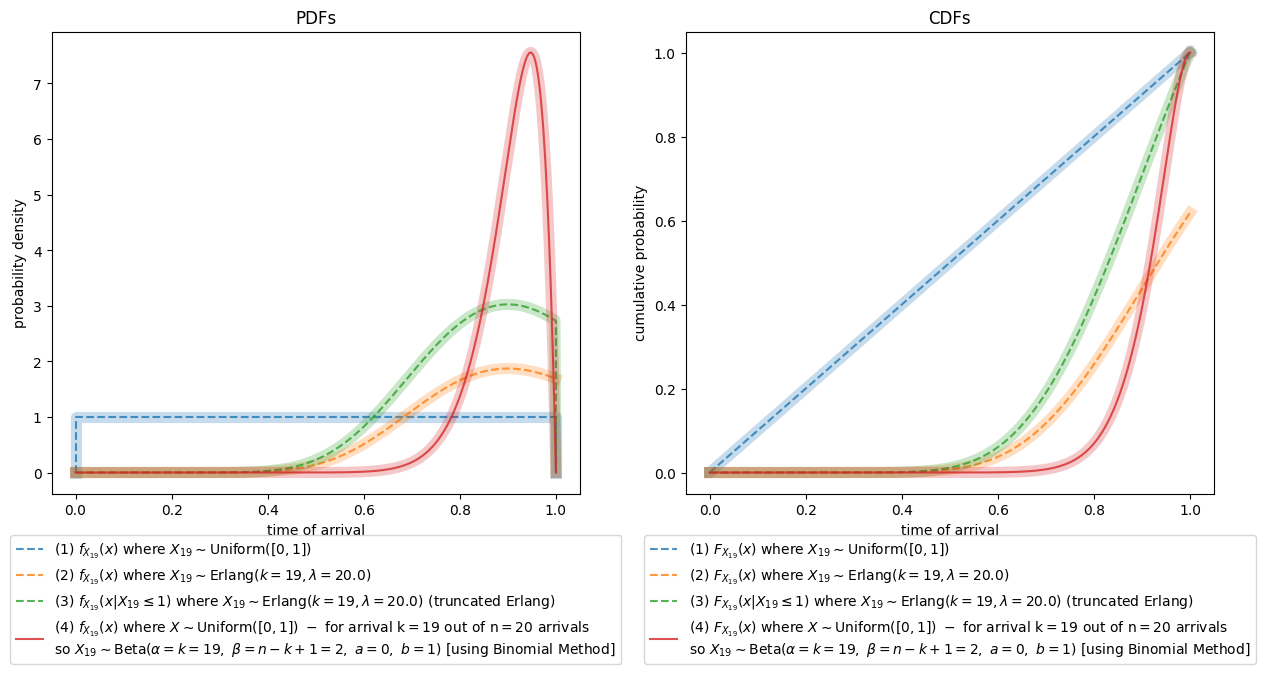

In [226]:
def k_of_n_uniform_a_b_using_binomial(a, b, n, k, RV_symbol=RV_symbol):
    '''If you have a uniform(a,b) distribution, and draw n RVs from it, and order them ascending order,
    finds the prob dist of the k'th RV '''

    def k_of_n_uniform_a_b_fitted_using_binomial(x):
        part1 = (b-a)**n
        sum_pdf_parts2345 = np.zeros_like(x)
        sum_cdf_parts234 = np.zeros_like(x)
        x_within_bounds = (x>a) & (x<b)
        for j in range(k, n+1):
            part2 = scipy.special.comb(n,j)     #n choose j

            #pdf bits:              (limit calculation to x_within_bounds to avoid divideByZero errors)
            pdf_part3 = (x[x_within_bounds]-a)**(j-1)
            pdf_part4 = (b-x[x_within_bounds])**(n-j-1)
            pdf_part5 = (j*(b-a)  -  n*(x[x_within_bounds]-a))
            # pdf_part5 = (j*(a+b-2*x)  +  n*(x-a))
            pdf_parts2345 = part2 * pdf_part3 * pdf_part4 * pdf_part5
            sum_pdf_parts2345[x_within_bounds] += pdf_parts2345

            #cdf bits:
            cdf_part3 = (x-a)**j
            cdf_part4 = (b-x)**(n-j)
            cdf_parts234 = part2 * cdf_part3 * cdf_part4 
            sum_cdf_parts234 += cdf_parts234
            
        pdf = sum_pdf_parts2345 / part1
        pdf[(x<a) | (x>b) ] = 0
        cdf = sum_cdf_parts234 / part1
        cdf[ (x>b) ] = 1
        cdf[(x<a) ] = 0

        return pdf, cdf

    name = (r'$f_{'+RV_symbol+'}(x) \ \mathrm{where}' 
            + ' \ X \sim  \mathrm{Uniform}(['+str(a)+','+str(b)+']) ' 
            + ' \mathrm{ \ - \ for \ arrival \ k='+str(k)
            + ' \ out \ of \ n='+str(n)+' \ arrivals}$'
            + '\n$ \mathrm{so} \ '+RV_symbol+'\sim  \mathrm{Beta}' 
            + r' (\alpha=k='+str(k)+', \ '
            + r' \beta=n-k+1='+str(n-k+1)+', \ '
            + r' a='+str(a) +', \ '
            + r' b='+str(b) +') $'
            + ' [using Binomial Method]')

    #we will shortly show that this is actually equivalent to the Beta distribution!
    scipy_frozen_RV = scipy.stats.beta(k, n-k+1, loc=a, scale=b-a)
    #scipy parameterises the 4-param beta using the start of the interval (loc=a) and the width of the interval (scale=b-a)

    return name, scipy_frozen_RV, k_of_n_uniform_a_b_fitted_using_binomial


list_PDFs.append(       k_of_n_uniform_a_b_using_binomial(a=a_start_time, b=b_end_time, 
                                n=n_total_num_vehicles, k=k_ferrari)
               )


_ = plot_multiple_PDFs_CDFs(list_PDFs, support_subset=[a_start_time, b_end_time], )

#### Method #2: PDF as Multinomial distribution

The above solution (Method #1) is correct, but is more complex than it needs to be with the summation. The summation is a result of the approach taken: We split arrivals into *two* groups, arrivals before $x$ and arrivals after. Then we expressed the CDF of $X_k$ in terms of the CDF of the binomial $K$, which is then a sum of the PMFs. So we end up with a summation, which persists through the differentiation into the PDF of $X_k$, and it isn't clear how we can simplify to get rid of the summation.  

Instead, we can jump straight to deriving the PDF, and only later get the CDF. To do this we must split arrivals into *three* groups instead of two :  
- arrivals before $x$, i.e. in $[a,x]$
- arrivals "in" $x$, i.e. in $[x,x+\delta]$
- arrivals after $x$, i.e. in $[x+\delta, b]$   

Recall that a PDF considers probability density, so we can consider the probability density of the arrival in a very small interval of $[x,x+\delta]$ where $\delta$ is very small. We can now say that $f_{X_k}$ is the probability density of having $k-1$ arrivals in $[a,x]$, $1$ arrival "in" $x$, i.e. in $[x,x+\delta]$, and $n-k$ arrivals after $x$, i.e. in $[x+\delta, b]$.    

The three groups, number of arrivals each contain, and probability of each arrival in that group, is summarised in this table:  

| Group | Description                       | Interval          | Number            | Probability               |  
| :-    | :-                                | :-                | :-                | :-:                       |
| $G_1$ | Arrival happened before $x$       | $[a,x]$           | $m_1=k-1$ arrivals    | $\frac{x-a}{b-a}$         |
| $G_2$ | Arrival happened "at" $x$         | $[x,x+\delta]$    | $m_2=1$ arrival       | $\frac{\delta}{b-a}$      |
| $G_3$ | Arrival happened after $x$        | $[x+\delta,b]$    | $m_3=n-k$ arrivals    | $\frac{b-x-\delta}{b-a}$  |
| All   | All groups                        | $[a,b]$           | $n$ arrivals      | $1$                       |

There are now three groups, so we must use the [Multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution), an extension of the Binomial distribution for more than two groups. The PMF of the Multinomial in general is   

$$f(m_1, m_2, ... ,m_k) = \frac{n!}{m_1! \ m_2! \ ... \ m_k!} p_1^{m_1} \ p_2^{m_2} \ ... \ p_k^{m_k}
= n! \ \prod_{i=1}^k \ \frac{p_i^{m_i}}{m_i!}
$$
where $m_1, m_2, ... ,m_k$ are the number of successes in each group, and $p_1, p_2, ... ,p_k$ are the corresponding probabilities. In our case, using the info from the table above:  


$$
\begin{align*}

\text{P}(X_k \in [x, x+\delta])
   & = f(m_1, m_2, m_3) 
\\ & = \frac{n!}{m_1! \ m_2! \ m_3!} p_1^{m_1} \ p_2^{m_2} \ p_3^{m_3}

\\ & = \frac{n!}{(k-1)! \ 1! \ (n-k)!}     
      \left(\frac{x-a}{b-a}         \right)^{k-1}   
      \left(\frac{\delta}{b-a}      \right)^{1}    
      \left(\frac{b-x-\delta}{b-a}  \right)^{n-k}

\\ & = k \binom{n}{k}
      \frac{1}{(b-a)^n}
      \left(x-a         \right)^{k-1}   
      \delta          
      \left(b-x-\delta  \right)^{n-k}
\end{align*}
$$

That is the probability $X_k$ falls in the interval $[x, x+\delta]$. For the probability *density* we must divide by the width of the interval. So 

$$
\begin{align*}
f_{X_k}(x)
& = \lim_{\delta \rightarrow 0^+} \frac{\text{P}(X_k \in [x, x+\delta])}  {\delta}

\\ & = \frac{1}{(b-a)^n} k \binom{n}{k}
      \left(x-a         \right)^{k-1}   
      \left(b-x         \right)^{n-k}
\end{align*}
$$
 as the $\delta$'s cancel and $\delta \approx 0$.   

Note that now, the PDF has no summation in it.

#### CDF

Using the above expression for the PDF, we can now compute the CDF:

$$
\begin{align*}
F_{X_k}(x') 
   & = \int_a^{x'} f_{X_k}(x) dx
\\ & = \int_a^{x'}  \frac{1}{(b-a)^n} \ k \ \binom{n}{k} \ (x-a)^{k-1} \ (b-x)^{n-k} \ \  dx
\\ & = \int_a^{x'} \frac{1}{(b-a)^n} \ k  \ \binom{n}{k} \ (x-a)^{k-1} \ (x-b)^{n-k} \ (-1)^{n-k} \ \  dx
\\ & = \frac{1}{(b-a)^n} \ k  \ \binom{n}{k} \ (-1)^{n-k} \ 
               \underbrace{\int_a^{x'} (x-a)^{k-1} \ (x-b)^{n-k} \ \  dx}_I
\end{align*}
$$

Focusing on the integral $I$, the obvious way to go is using integration by parts. Just doing that once won't suffice; we would have to do this iteratively, until either $(x-a)^{k-1}$ disappears or $(x-b)^{n-k}$ does. So we would end up with a summation where the number of terms would depend on $n$ and $k$.  

A better approach is to restate the formula and then use the [Binomial theorem](https://en.wikipedia.org/wiki/Binomial_theorem) to turn it into a summation inside the integral, and go from there.  

Let $y=x-a$ and $c=a-b$, and using the Binomial identity $(u+v)^N = \sum_{i=0}^N \binom{N}{i} \ u^{N-i} \ v^i $ :

$$
\begin{align*}
  I & =  \int_a^{x'} (x-a)^{k-1} \ (x-b)^{n-k} \ \  dx
\\  & =  \int_{a-a}^{x'-a} y^{k-1} \ (y+a-b)^{n-k} \ \  dy
\\  & =  \int_{0}^{x'-a} y^{k-1} \ (y+c)^{n-k} \ \  dy
\\  & =  \int_{0}^{x'-a} y^{k-1} \ \sum_{i=0}^{n-k} \binom{n-k}{i} \ y^{n-k-i} \ c^i \ \  dy
\\  & =  \int_{0}^{x'-a} \ \sum_{i=0}^{n-k} \binom{n-k}{i} \ c^i \ y^{n-k-i} \ y^{k-1}  \ \  dy

\\  & =  \sum_{i=0}^{n-k} \binom{n-k}{i} \ c^i \ \int_{0}^{x'-a} \ y^{n-i-1}   \ \  dy
\\  & =  \sum_{i=0}^{n-k} \binom{n-k}{i} \ c^i \ \left[ \frac {y^{n-i}}{n-i} \right]_{0}^{x'-a}   
\\  & =  \sum_{i=0}^{n-k} \binom{n-k}{i} \ (a-b)^i \ \left[ \frac {(x'-a)^{n-i}}{n-i} \right]

\end{align*}
$$

Returning to the CDF using the above:  

$$
\begin{align*}
F_{X_k}(x') 
   & = \frac{1}{(b-a)^n} \ k  \ \binom{n}{k} (-1)^{n-k} \ \int_a^{x'} (x-a)^{k-1} \ (x-b)^{n-k} \ \  dx
\\
\therefore \ F_{X_k}(x) 
   & = \frac{(-1)^{n-k}}{(b-a)^n} \ k  \ \binom{n}{k}  \ 
         \sum_{i=0}^{n-k} \binom{n-k}{i} \ (a-b)^i \ \left[ \frac {(x-a)^{n-i}}{n-i} \right]
\end{align*}
$$

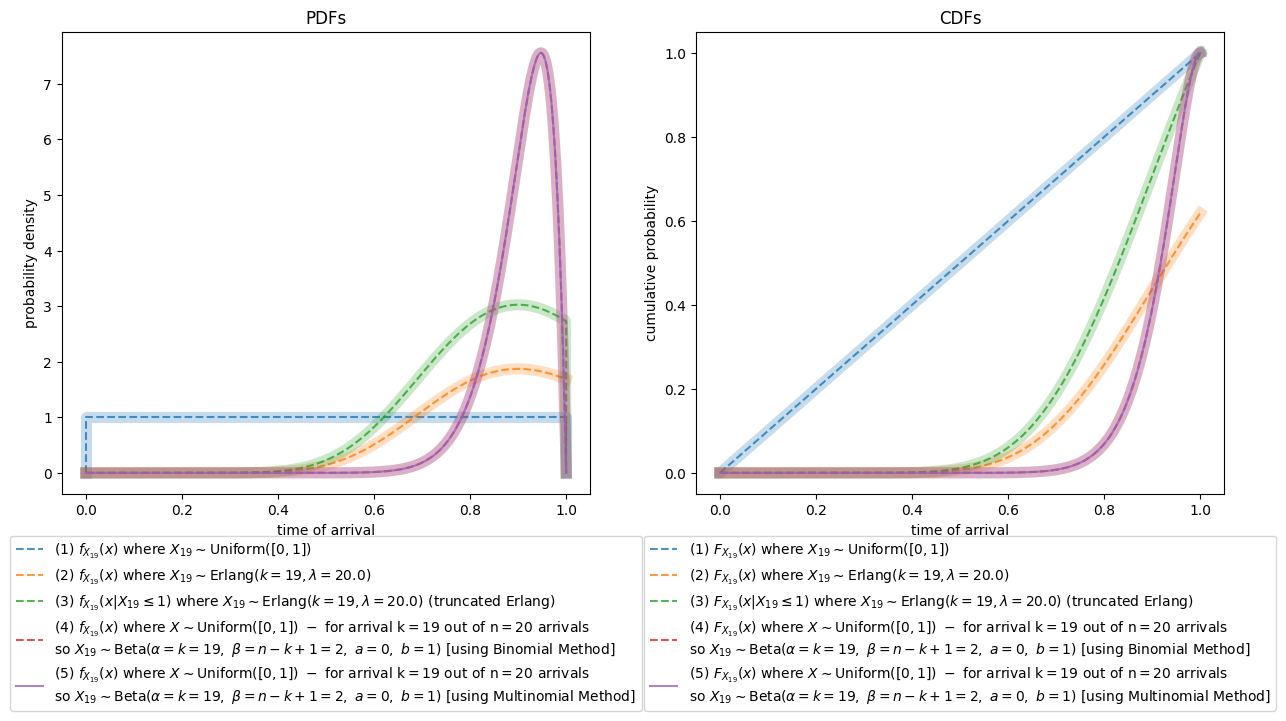

In [227]:
def k_of_n_uniform_a_b_using_multinomial(a, b, n, k, RV_symbol=RV_symbol):
    '''If you have a uniform(a,b) distribution, and draw n RVs from it, and order them ascending order,
    finds the prob dist of the k'th RV '''

    def k_of_n_uniform_a_b_fitted_using_multinomial(x):
        part1 = scipy.special.comb(n,k, exact=True) * k
        denominator = (b-a) ** (n)

        pdf_part2 = (x-a) ** (k-1)
        pdf_part3 = (b-x) ** (n-k)
        pdf = part1*pdf_part2*pdf_part3 / denominator
        pdf[(x<a) | (x>b) ] = 0

        cdf_part2=(-1)**(n-k)
        sum_cdf_parts3456 = np.zeros_like(x)
        for j in range(0, n-k+1): 
            cdf_part3 = scipy.special.comb(n-k, j, exact=True) 
            cdf_part4 = (a-b)**j
            cdf_part5 = (x-a)**(n-j)
            cdf_part6 = n-j
            # print(j, '(x-a)', (x-a), '(n-j)', (n-j), '(x-a)**(n-j)', cdf_part5,)
            # print(j, part1, cdf_part2, cdf_part3, cdf_part4 , cdf_part5.round(2), cdf_part6, denominator)
            cdf_parts3456 = cdf_part3 * cdf_part4 * cdf_part5 / cdf_part6
            sum_cdf_parts3456 = sum_cdf_parts3456 + cdf_parts3456

        cdf = part1 * cdf_part2 * sum_cdf_parts3456 / denominator
        # print(cdf_part5)
        # print(sum_cdf_parts3456)
        # print(cdf)
        cdf[ (x>b) ] = 1
        cdf[ (x<a) ] = 0

        # print(cdf[-1], type(cdf[-1]), cdf[-2], type(cdf[-2]), cdf_part5[-2], type(cdf_part5[-2]), x[-2], type(x[-2]))

        return pdf, cdf


    name = (r'$f_{'+RV_symbol+'}(x) \ \mathrm{where}' 
            + ' \ X \sim  \mathrm{Uniform}(['+str(a)+','+str(b)+']) ' 
            + ' \mathrm{ \ - \ for \ arrival \ k='+str(k)
            + ' \ out \ of \ n='+str(n)+' \ arrivals}$'
            + '\n$ \mathrm{so} \ '+RV_symbol+'\sim  \mathrm{Beta}' 
            + r' (\alpha=k='+str(k)+', \ '
            + r' \beta=n-k+1='+str(n-k+1)+', \ '
            + r' a='+str(a) +', \ '
            + r' b='+str(b) +') $'
            + ' [using Multinomial Method]')
    
    #we will shortly show that this is actually equivalent to the Beta distribution!
    scipy_frozen_RV = scipy.stats.beta(k, n-k+1, loc=a, scale=b-a)
    #scipy parameterises the 4-param beta using the start of the interval (loc=a) and the width of the interval (scale=b-a)

    return name, scipy_frozen_RV, k_of_n_uniform_a_b_fitted_using_multinomial 


list_PDFs.append(k_of_n_uniform_a_b_using_multinomial(a=a_start_time, b=b_end_time, 
                                n=n_total_num_vehicles, k=k_ferrari)
       )

_ = plot_multiple_PDFs_CDFs(list_PDFs, support_subset=[a_start_time,b_end_time], )

\- the above plots demonstrate clearly that the two derivations both give the same result, as the last two lines overlap.  

Note: for some other values of $n$ and $k$, the function above doesn't produce robust results. Regarding this, and for a "fixed" version of the function, see Appendix 1 - numerical issues.  

#### Method #3: Mathematical direct derivation

In the first two methods, the approach was based on an understanding that a fixed number of Poisson arrivals within a fixed timeframe are Uniformly distributed. Through that, the problem was simplified to $k$-order statistics of the uniform distribution. And then it could be solved, either by looking at the CDF of the $k$'th arrival as a Binomial, or by looking at the PDF of the $k$'th arrival as a Multinomial.  

We can now show that the same solution will be arrived at if we do not use the fact that the arrivals are each uniform, but using only the formulae which make up the Poisson family. Just pushing those formulae straight into Bayes rule will also solve the problem, albeit without a full understanding of what is happening.  



We want to find the PDF of the $k$'th arrival, given that there were $n$ arrivals in total over the interval $[a,b]$. To make notation clearer, I'll refer to this PDF here as $f_{X_{k,n}}$. So we need to find    

$$\begin{align*}
f_{X_{k,n}} 
   & = f_{X_k}{(x \ \ | \ \ n \ \text{arrivals within the interval } [a,b])} 
\\ & = f_{X_k}{(x \ \ | \ \  n-k \ \text{arrivals within the remaining period after} \ x \text{, i.e. in interval} \ [x,b])} 
\end{align*}$$    

Again we can use [Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), which states that:  
$$
\text{For events:}  \ \ \
 \text{P}(A \mid B) = \frac{\text{P}(B \mid A) \, \text{P}(A)}{\text{P}(B)}. 
\ \ \ 
\text{For continuous RVs:}  \ \ \ \ 
f_{X|Y}(x \  |  \  y) = \frac{f_X(x)   \,  f_{Y|X}(y \  | \   x) }  {f_Y(y)}
$$
 Let us split this into three parts:    A $f_X(x)$, B $f_{Y|X}(y  \ | \   x)$ and C $f_Y(y)$ and proceed.



**A. Part A $f_X(x)$  :**  

This is the unconditional distribution of the time of the $k$'th arrival, starting at time $a$, which is given by the Erlang PDF:
$$f_{X_k}(x) = \frac{\lambda^k (x-a)^{k-1} e^{-\lambda (x-a)}}        {(k-1)!}$$


**B. Part B $f_{N|X_k}(n \  | \  X_k = x)$  :**  

$N$ refers to the number of arrivals over the interval $[a,b]$, which is described by the Poisson PMF. Here, we need to look at that PMF conditioned on the fact that the $k$'th arrival happened at time $x$. Due to [memorylessness property of the Poisson process](https://en.wikipedia.org/wiki/Memorylessness#The_memoryless_distribution_is_an_exponential_distribution), that is equal to the PDF of $n-k$ arrivals happening in the remaining time, in the interval $[x,b]$.
  
We use the PMF of the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) of $A$, the number of arrivals in the remaining time. We substitute $\lambda(b-x)$ for $\lambda$ in the Poisson PMF, $A \sim \text{Poiss}(\lambda(b-x))$, since the rate is proportional to interval length, and find the probability $A=n-k$ in that interval, i.e. all later arrivals happen in this interval:  

 $$\begin{align*}
 f_{N|X_k}(n \  | \  X_k = x)
   & =   f_{A|X_k}(n-k \  | \  X_k = x)
 \\ & =  \frac{  e^{-\lambda (b-x)}  (\lambda (b-x))^{n-k} }  {(n-k)!}  
 \\ & =  \frac{  e^{\lambda x - \lambda b }  \lambda^{n-k} (b-x)^{n-k} }  {(n-k)!}  
 \end{align*}
 $$ 


**C. Part C $f_N(n)$  :**  

This can simply be found using the Poisson PMF for $n$ arrivals over the entire interval $[a,b]$. As rate per unit time is $\lambda$, rate per full interval is $\lambda (b-a)$. So:

$$\begin{align*}
f_N(n) 
   & = \frac{(\lambda (b-a))^n \ e^{-\lambda (b-a)} }     {n!}
\\ & = \frac{\lambda^n \ (b-a)^n \ e^{\lambda a -\lambda b} }     {n!}

 \end{align*}
$$



**Putting this into Bayes formula**

In Parts A-C we have already calculated the numerator and denominator. All that remains is the pure simple joy of cancelling everything out:

$$\begin{align*}
f_{X_{k,n}}(x) = f_{X_{k}|N} (x \ | \ n)
   & = \frac{f_{X_{k}}(x)  \,  f_{N|X_k}(n \  | \  X_k = x)   }  {f_{N}(n)}


\\ & = \dfrac{    \ \ \left[ \dfrac{\lambda^k e^{-\lambda (x-a)} (x-a)^{k-1} }        {(k-1)!}     \right]    \ \   
                  \left[\dfrac{ \lambda^{n-k}  e^{\lambda x - \lambda b }  (b-x)^{n-k} }  {(n-k)!} \right]  \ \   }  
                  {\left[\dfrac{\lambda^n e^{\lambda a -\lambda b} \ (b-a)^n \ }     {n!}\right]}


\\ & = \frac {n!}  {(k-1)! \ (n-k)!} \ \ 

\dfrac{    \lambda^k  \lambda^{n-k}    }  
                  {\lambda^n } \ \
\dfrac{     e^{\lambda a - \lambda x}        \ \   
                   e^{\lambda x - \lambda b }      }  
                  {  e^{\lambda a -\lambda b}}  \ \ 

\dfrac{    \ \   (x-a)^{k-1}        \ \   
                      (b-x)^{n-k}   \ \   }  
                  { \ (b-a)^n \ }


\\ & = k \binom{n}{k} \ \ 


\dfrac{    \ \   (x-a)^{k-1}        \ \   
                      (b-x)^{n-k}   \ \   }  
                  { \ (b-a)^n \ }


\end{align*}
$$

\- which is of course the same PDF as the one we derived earlier in method 2.  

Note particularly that all the $\lambda$ terms cancelled out. This is as explained, in this situation it isn't a Poisson-related distribution, but a "$k$'th order of the Uniform distribution" distribution, so $\lambda$ is irrelevant to the distribution.  

#### Equivalence of the two sets of formulae

So we have derived two equivalent formulae for the PDF of $X_k$:  

$$
\begin{align*}
(1) \ \ \ \ f_{X_k}(x)
&  = \frac{1}{(b-a)^n}    \    k \binom{n}{k}
      \left(x-a         \right)^{k-1}   
      \left(b-x         \right)^{n-k}  
\\ 
(2) \ \ \ \ f_{X_k}(x) 
   & = \frac{1}{(b-a)^n} \ \sum_{j=k}^{n} \ \binom{n}{j} \ 
         \bigg[ (x-a)^{j-1} \ (b-x)^{n-j-1} \ \big[ j(b-a) - n(x-a)  \big] \  \bigg]
\end{align*}
$$

And two equivalent formulae for the CDF of $X_k$:  


$$
\begin{align*}
(1) \ \ \ \ F_{X_k}(x) 
   & = \frac{(-1)^{n-k}}{(b-a)^n} \ k  \ \binom{n}{k}  \ 
         \sum_{i=0}^{n-k} \binom{n-k}{i} \ (a-b)^i \ \left[ \frac {(x-a)^{n-i}}{n-i} \right]
\\
(2) \ \ \ \ F_{X_k}(x) 
   & =  \frac{1}{(b-a)^n} \ \sum_{j=k}^{n} \ \binom{n}{j} \ (x-a)^j \ (b-x)^{n-j}
\end{align*}
$$

It is not trivial to derive one formula from the other. For example, see Appendix 2 where we show that `sympy` fails in trying to simplify the form with the summation into the form without, and cannot recognise that the two are equivalent. Wolfram also fails to do this in the general case, although Wolfram succeeds when $a=0$ and $b=1$, as discussed in the Appendix.  

#### From the above PDF it follows that $X_k$ follows a Beta distribution

So we have derived the PDF for the $k$'th arrival of a Poisson Process when it is known that there were exactly $n$ arrivals in the interval $[a,b]$:


$$
\begin{align*}
 f_{X_{k,n}}(x)
&  = \frac{1}{(b-a)^n}    \    k \binom{n}{k}
      \left(x-a         \right)^{k-1}   
      \left(b-x         \right)^{n-k}
\end{align*}
$$

The interesting thing is that this is a Beta distribution!  

The [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), with support $[0,1]$, is commonly defined with two parameters, $\alpha$ and $\beta$. The PDF for such an RV $Z \sim \text{Beta}(\alpha, \beta)$ is  

$$f_Z(z) = \frac{z^{\alpha-1} (1-z)^{\beta-1}} {\text{B}(\alpha, \beta)}$$
where $\text{B}(\alpha, \beta)$, the [Beta function](https://en.wikipedia.org/wiki/Beta_function), is a normalising constant (to ensure that the integral of the above expression, over its support $[0,1]$, is equal to $1$, so that it will be a valid probability distribution).  

The Beta distribution can also be defined with [four parameters](https://en.wikipedia.org/wiki/Beta_distribution#Four_parameters), $Z \sim \text{Beta}(\alpha, \beta, a, b)$, such that its support will be $[a,b]$. Then, the PDF for such an RV is  

$$f_Z(z) = \frac{(z-a)^{\alpha-1} (b-z)^{\beta-1}} {\text{B}(\alpha, \beta) (b-a)^{\alpha+\beta-1}}$$  

Our formula for the PDF of $X_k$, the $k$'th arrival, is clearly very similar to the Beta distribution PDF. If we say $\alpha=k$ and $\beta=n-k+1$, then 
$$\begin{align*}
f_Z(z) 
   & = \frac{(z-a)^{\alpha-1} (b-z)^{\beta-1}} {\text{B}(\alpha, \beta) (b-a)^{\alpha+\beta-1}}
\\ & = \frac{(z-a)^{k-1} (b-z)^{(n-k+1)-1}} {\text{B}(k, n-k+1) (b-a)^{k+(n-k+1)-1}}
\\ & = \frac{(z-a)^{k-1} (b-z)^{n-k      }} {\text{B}(k, n-k+1) (b-a)^{n}}
\end{align*}
$$  .  


The truth is that we can already state with certainty that the PDF formula we derived is the same formula as the Beta PDF: The part which depends on $z$, i.e. $(z-a)^{k-1} (b-z)^{n-k}$, is identical to the part in the formula we derived which depends on $x$, i.e. $(x-a)^{k-1} (b-x)^{n-k}$. All the remaining elements of both formulae are simply [normalising constants](https://en.wikipedia.org/wiki/Normalizing_constant), to ensure the PDF integrates to 1. And as the main part of the two PDFs is identical, we can be sure that their normalising constants will be identical too.  

Just to follow this through: an interesting thing about the Beta function $\text{B}(\alpha, \beta)$ is that when its parameters $\alpha, \beta$ are positive integers, it [can be expressed in terms of factorials of $\alpha, \beta$](https://en.wikipedia.org/wiki/Beta_function#Properties):

$$\text{B}(\alpha, \beta) = \frac{(\alpha-1)! (\beta-1)!}{(\alpha + \beta - 1)!}$$

So in our case where $\alpha=k$ and $\beta=n-k+1$, 

$$\begin{align*}
\text{B}(k, n-k+1)
& = \frac{(k-1)! ((n-k+1)-1)!}{(k + (n-k+1) - 1)!}
\\ & = \frac{(k-1)! (n-k)!}{n!}
\\ & = \frac{(k-1)! (n-k)!}{n!}
\\ & = \left[ k \binom{n}{k} \right]^{-1}
\end{align*}
$$


Using this we can go back to the earlier formula:  

$$\begin{align*}
f_Z(z) 
& = \frac{(z-a)^{k-1} (b-z)^{n-k}} {\text{B}(k, n-k+1) (b-a)^{n}}

\\ & = \frac{1}{(b-a)^n} \ k \binom{n}{k} \ 
         \bigg[ (z-a)^{k-1} \ (b-z)^{n-k}  \bigg]
\end{align*}
$$  .  
<br>

**So we see that indeed the formula we derived from scratch for the PDF of the $k$'th arrival, is actually the PDF of the Beta distribution!**

### Getting back to the court case 

<img src="img\confused judge c.jpg" style="float: right;"  width="70" height="100"></img>  
You have spent the last 3 days in court, explaining to the judge all about probability distributions, Bayes rule, Uniform, Poisson, Exponential, Erlang and Beta PDFs. He has been getting more and more confused.   

"But what does it all mean?" he cries. "Should I find him innocent or guilty?" 

In [228]:
print(probability_outside_alibi(distribution_func=k_of_n_uniform_a_b_using_binomial(a=a_start_time, b=b_end_time, 
                                n=n_total_num_vehicles, k=k_ferrari), 
                    alibi_times=alibi_times) )
print(probability_outside_alibi(distribution_func=k_of_n_uniform_a_b_using_multinomial(a=a_start_time, b=b_end_time, 
                                n=n_total_num_vehicles, k=k_ferrari), 
                    alibi_times=alibi_times) )


0.024312624865160615
0.024312624865162835


"Your honour - the numbers don't lie! The chance that the robbery occurred before the alibi is less than 2.5%! We can confidently reject the baseless hypothesis it was Tom Robinson!" 

<img src="img\evil angry lawyer.jpg" style="float: right;" width="70" height="100"></img>
Tulkinghorn has gone a vivid shade of puce and is wearing an ugly expression.  

"Your honour! I object! The man isn't a qualified lawyer! He is hostis humani generis! I insist on bringing my own contact, a fully qualified lawyer, who will affirm that all these calculations are wrong! I will myself fund this expert, and personally explain to him all the background of the case - for we must leave no stone unturned in our quest for Justice! Fiat justitia et pereat mundus!"  

You see the judge wavering. This is no time for half measures. The last, awful, ultimate tool of the Data Scientist must be unleashed.  

"Your honour; my learned friend", you intone. "Are you familiar with Monte Carlo?"

### Monte Carlo simulations

To help the good judge be a bit more confident in our calculations, which were rather long-winded, we can run a Monte Carlo simulation.   

#### Generate data 

First, we write functions which will generate "$k$ of $n$" RVs for both Poisson arrivals (for any $\lambda$), and for ordered Uniform distributions:

In [229]:
def generate_samples_k_of_n_poisson_arrivals_in_interval_ab(Lambda, k, n, a, b, num_samples):

    poisson_samples_kth_arrival = np.array([])

    while len(poisson_samples_kth_arrival)<num_samples:

        # create an array where each row is inter-arrival times of a Poisson process
        # total n+1 arrivals in each row (so we can be sure n+1'th arrival happened after end of interval)
        interarrival_gaps = np.random.exponential(scale=1/Lambda, size=(num_samples,n+1))

        # create an array where each row is time from start of those arrivals
        # we do this by cumulative summing 
        exp_arrivals = np.cumsum(interarrival_gaps, axis=1)#.shape

        #add start time of interval
        exp_arrivals += a

        #filter to make sure only those with EXACTLY n arrivals within the interval remain
        correct_num_arrivals_in_interval = (exp_arrivals[:,n-1] < b) & (exp_arrivals[:,n] > b)
        # exp_arrivals = exp_arrivals[correct_num_arrivals_in_interval]

        # append times of k'th arrival, for all rows which meet criteria (i.e. correct number of arrivals within interval)
        poisson_samples_kth_arrival = np.hstack([poisson_samples_kth_arrival,  
                exp_arrivals[correct_num_arrivals_in_interval, k-1]  ])

    poisson_samples_kth_arrival = poisson_samples_kth_arrival[:num_samples]

    return poisson_samples_kth_arrival


In [230]:
def generate_samples_k_of_n_ordered_uniforms_in_interval_ab(k, n, a, b, num_samples):

    # create an array where each row has n realisations of the uniform RV over the interval
    # total n arrivals in each row
    uniforms = np.random.uniform(low=a, high=b, size=(num_samples,n))

    # create an array where each row is ORDERED uniforms
    # we do this by sorting the above
    sorted_uniforms = np.sort(uniforms, axis=1)#.shape

    # extract times of k'th sorted uniform
    uniform_samples_kth_value = sorted_uniforms[:, k-1]

    return uniform_samples_kth_value


#### Demonstrate that when we know how many arrivals happened in an interval, they follow a Uniform distribution


Now we can go ahead and generate sequences for both Poisson arrivals (for any $\lambda$), and for ordered Uniform distributions. We can then order those sequences and plot the quantiles of the empirical CDFs of the two sequences together. Both sequences will be generated to have the same length `sequence_length`, so (once the sequences have been ordered), each corresponding pair in the two sequences have the same quantile. For example, the 10th value in each sequence in a sequence of length 1000 represents the value 1% from the beginning.   

This technique is known as a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) and is a visual way of comparing two distributions. When the distributions are roughly equal, each quantile will be roughly equal, so the scattered points will roughly be on the $y=x$ line. Usually, QQ plots are used to compare quantiles of empirical data with quantiles of the theoretical distribution you are comparing it with; here, both are quantiles of empirical data.    

> For example, if we were comparing two datasets both generated from the $\text{Uniform}(0,1)$ distribution, we would expect the 10% quantile to be approx $0.1$ from each, so one point would be plotted at around $(0.1, 0.1)$. And similarly all the points would fall on $y=x$. Whereas if the second distribution was generated from the $\text{Uniform}(10,20)$ distribution, we would expect the 10% quantile to be approx $0.1$ from the first distribution but $11$ from the second, so one point would be plotted at around $(0.1, 11)$. And similarly none of the points would be expected to fall on $y=x$, but they would still be in a straight line. If the second distribution wasn't $\text{Uniform}$ at all, then the points wouldn't be in a straight line.   

In the plots below, several examples are plotted, with different values of $k$ and $n$ and $\lambda$. They all fall on the $y=x$ line. This clearly demonstrates that when it is known that there are $n$ Poisson arrivals in an interval, that the $k$'th arrival has the same distribution as the $k$'th ordered value of $n$ uniformly distributed values, for any $k,n$.

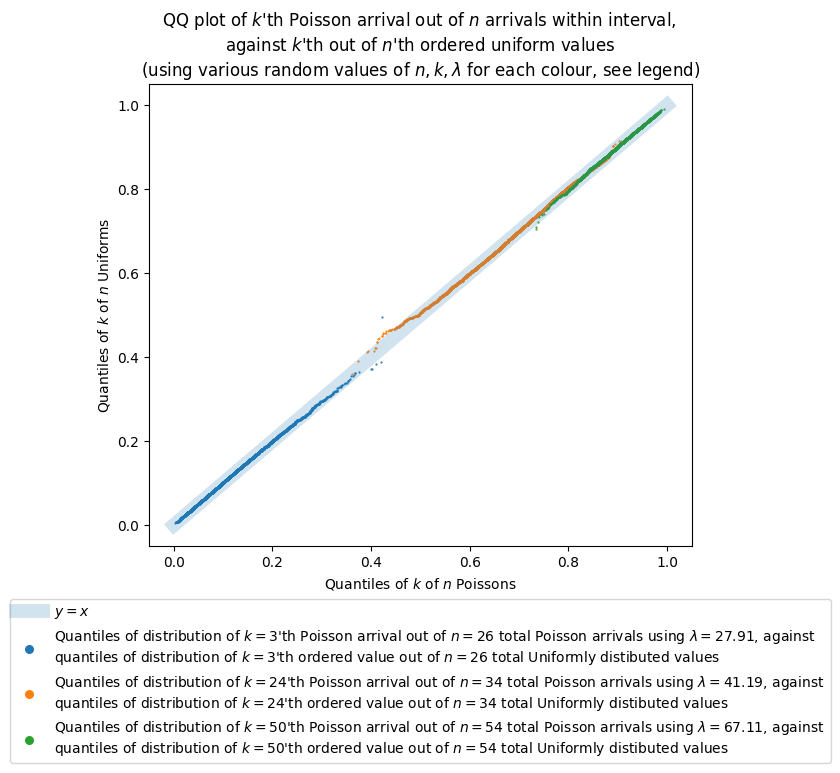

In [231]:
num_examples_to_plot = 3
sequence_length = 10000
# a_start_time,b_end_time = -3,10

#choose n and k randomly
np.random.seed(9)           #this seed works nicely 
n_rand_selection = np.sort(np.random.choice(np.arange(20,80), size=num_examples_to_plot, replace=False))
k_rand_selection = (np.sort(np.random.uniform(0.1,1, size=num_examples_to_plot)) * n_rand_selection).astype(int)
# print(n_rand_selection, k_rand_selection)

plt.figure(figsize=(7,6))
plt.title('QQ plot of $k$\'th Poisson arrival out of $n$ arrivals within interval, '
            +'\nagainst $k$\'th out of $n$\'th ordered uniform values'
            +'\n(using various random values of $n, k, \lambda$ for each colour, see legend)')

plt.xlabel('Quantiles of $k$ of $n$ Poissons')
plt.ylabel('Quantiles of $k$ of $n$ Uniforms')

#plot y=x line
plt.plot([a_start_time,b_end_time], [a_start_time,b_end_time], lw=10, alpha=.2, label='$y=x$')

for i in range(num_examples_to_plot):
    n_rand = n_rand_selection[i]
    k_rand = k_rand_selection[i]
    lambda_MLE_rand = n_rand / (b_end_time-a_start_time)
    lambda_rand = lambda_MLE_rand * (.75 + .5*np.random.random())
    poisson_samples_kth_arrival = generate_samples_k_of_n_poisson_arrivals_in_interval_ab(Lambda=lambda_rand, 
        k=k_rand, n=n_rand, a=a_start_time, b=b_end_time, 
        num_samples=sequence_length)
    uniform_samples_kth_value = generate_samples_k_of_n_ordered_uniforms_in_interval_ab(
        k=k_rand, n=n_rand, a=a_start_time, b=b_end_time, 
        num_samples=sequence_length)

    plt.scatter(np.sort(poisson_samples_kth_arrival), np.sort(uniform_samples_kth_value), s=.3, alpha=1,
        label='Quantiles of distribution of $k='+str(k_rand) +'$\'th Poisson arrival out of $n='+str(n_rand)+'$ total Poisson arrivals'
        + ' using $\lambda='+str(np.round(lambda_rand,2))+'$, against \n'
        + 'quantiles of distribution of $k='+str(k_rand) +'$\'th ordered value out of $n='+str(n_rand)+'$ total Uniformly distibuted values'
        )

# to have each example on a separate plot, indent all remaining lines in cell. Otherwise shows them all on one plot

#make a legend on the side. Set opacity/alpha=1 for all markers so they are clear on the legend
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),)
for marker in legend.legendHandles[1:]: 
    marker.set(alpha=1, sizes=[30])

plt.show()

The above shows clearly that, for the same $n$ and $k$, the Poisson and Uniform have the same distribution, irrespective of $\lambda$.  

#### Plotting empirical PDF, CDF, and QQplots  

We can now show that data generated in such a way as to be similar to the cars arrivals in our story follows the distribution shown. We can show this in three ways:  

1) By plotting the histogram of the generated data as frequencies on top of the PDFs of the distributions described. The histogram will match the correct distribution.  

2) By plotting the empirical CDF of the data on top of the theoretical CDFs. Again, the one which matches is the correct distribution.  

3) Finally, by plotting the QQ-plot of the quantiles of the generated data against the quantiles of the theoretical distributions. The theoretical distribution whose plot is close to the $y=x$ line can then be identified as the correct distribution. (The advantage of this method over the previous two is that small differences in the tail regions show up more in this method).   

In the following figures, the three axes correspond to these three plots:


In [232]:
 
def plot_multiple_PDFs_CDFs_QQs(list_PDFs, empirical_data, support_subset=[a_start_time, b_end_time], display_or_return_ax='display', axes=None):
    '''Plots PDFs and CDFs for all provided distributions on two axes over the specified support.
    Also plots QQs between all provided distributions and empirical_data.
    
    Args:
        list_PDFs       :       a list of functions. Each function in the list represents a different PDF.
                                The final item in the list is the "best" one, the others are only shown to contrast to it
                                So the final item is shown with an unbroken line, as opposed to all other items.
                                Each function (for each distribution) returns the following:
                                    'name'      :   the name of the PDF, for the legend.
                                    'frozen_RV' :   the scipy frozen RV for the distribution.
                                                        If not None, this is plotted, just to check - should overlap with plot of my_func.
                                    'my_func'   :    a function which describes the distribution by 
                                                        returning its PDF and CDF when given x.
        empirical_data  :       The generated data whose histogram will be plotted on the PDFs; 
                                    and whose empirical CDF will be plotted on the CDFs; 
                                    and whose quantiles will be plotted against the quantiles of the various proposed theoretical distributions.
        support_subset  :       the part of the support of the distribution to show.
                                For example, if the PDF is the standard normal (whose support is all real numbers),
                                this could be given as [-3, 3] so that the plot will cover that range.
        display_or_return_ax:   specifies whether the plot should be displayed, or returned (e.g. for modification)
        axes            :       the axes to plot on (a tuple - one ax for pdf and one for cdf), if provided
                                If not provided, creates new.

    Returns:
        axes            :       if display_or_return_ax=='return', it returns the axes for pdf and cdf and QQ.
                                Otherwise this function plots the axes and returns None.
    '''

    fig, (ax_pdf, ax_cdf, ax_qq) = plt.subplots(1,3, figsize=(24,7))
    empirical_data_colour = colours_cycle[(len(list_PDFs)) % len(colours_cycle)]   #choose colour for empirical overlays

    (ax_pdf, ax_cdf) = plot_multiple_PDFs_CDFs(list_PDFs, support_subset=[a_start_time,b_end_time], 
            display_or_return_ax='return', axes=(ax_pdf, ax_cdf))

    # add empirical data frequency info to pdf plot to compare against plotted distributions
    ax_pdf.hist(empirical_data, bins=len(empirical_data)//500,    #each bin will have approx 500 points in it
        color=empirical_data_colour, histtype='step', #alpha=0.3, 
        density=True, label='Monte Carlo simulation - frequency densities histogram')
    ax_pdf.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),)

    # add empirical data frequency info to cdf plot to compare against plotted distributions
    ax_cdf.plot(np.hstack([[0], np.sort(empirical_data)]), 
            np.arange(0, len(empirical_data)+1) / len(empirical_data), 
            c=empirical_data_colour, label='Monte Carlo simulation - cumulative densities')
    ax_cdf.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),)

    # add QQ plots to compare theoretical distributions in list to empirical data
    # ax_qq.plot([0,1], [0,1])
    ax_qq.set_title('QQ plots \nto compare all proposed theoretical distributions, to empirical generated data')
    ax_qq.set_xlabel('Theoretical quantiles for each proposed distribution')
    ax_qq.set_ylabel('Empirical quantiles of generated data')

    for i, (name, scipy_frozen_RV, distribution_func) in enumerate(list_PDFs):
        # choose a unique colour for the PDF and CDF for this item
        colour = colours_cycle[i%len(colours_cycle)] 

        label = label='('+str(i+1)+') ' + name

        if scipy_frozen_RV is not None:
            # scipy_theoretical_Qs = scipy_frozen_RV.ppf(np.arange(0, len(empirical_data)+1) / len(empirical_data))
            # ax_qq.scatter(scipy_theoretical_Qs, np.hstack([[0], np.sort(empirical_data)]), #label=dist_name, linestyle=':',
            scipy_theoretical_Qs = scipy_frozen_RV.ppf(np.arange(1, len(empirical_data)+1) / len(empirical_data))
            ax_qq.scatter(scipy_theoretical_Qs, np.sort(empirical_data), #label=dist_name, linestyle=':',
                  c=colour, s=.3, alpha=1, label=label)  

            # scipy_cdf = scipy_frozen_RV.cdf(x)
            # ax_cdf.plot(x, scipy_cdf, #label=dist_name, linestyle=':', 
            #     lw=8, c=colour, alpha=.1 )  

        # distribution_func_pdf, distribution_func_cdf = distribution_func(x)
        # ax_pdf.plot(x, distribution_func_pdf, label=label, c=colour,
        #     linestyle=('-' if i==len(list_PDFs)-1 else '--') , alpha=.8, )
        # ax_cdf.plot(x, distribution_func_cdf, label=label.replace('$f_', '$F_'), c=colour,
        #     linestyle=('-' if i==len(list_PDFs)-1 else '--') , alpha=.8, )
    ax_qq.set_xlim(ax_cdf.get_xlim())
    ax_qq.set_ylim(ax_cdf.get_xlim())
    # print(ax_cdf.get_xlim())

    #plot y=x line
    ax_qq.plot([a_start_time,b_end_time], [a_start_time,b_end_time], lw=10, 
            c=empirical_data_colour, alpha=.2, label='$y=x$')

    qq_legend = ax_qq.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),)
    for marker in qq_legend.legendHandles[1:]: 
        marker.set(alpha=1, sizes=[30])

    if display_or_return_ax=='display':
        plt.show()
    elif display_or_return_ax=='return':
        return (ax_pdf, ax_cdf)


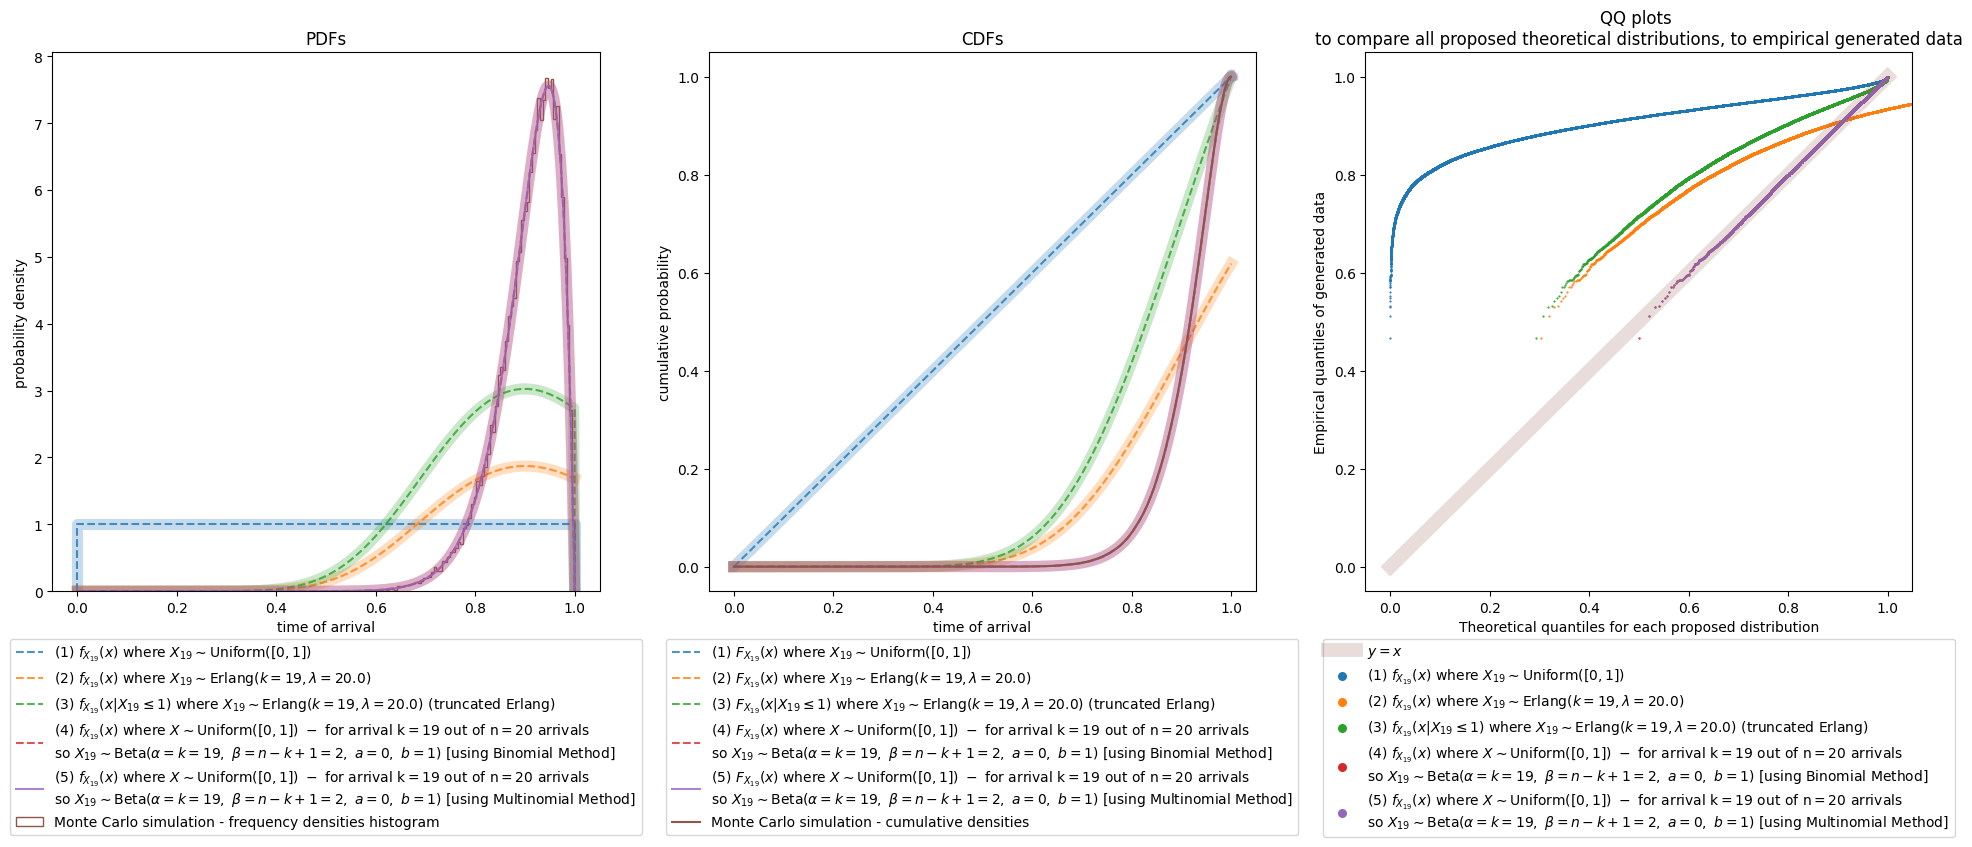

In [233]:

samples_kth_arrival = generate_samples_k_of_n_poisson_arrivals_in_interval_ab(Lambda=lambda_MLE*1.0, 
        k=k_ferrari, n=n_total_num_vehicles, a=a_start_time, b=b_end_time, 
        num_samples=50003)

plot_multiple_PDFs_CDFs_QQs(list_PDFs, empirical_data=samples_kth_arrival, support_subset=[a_start_time, b_end_time])

So the simulated data really couldn't be closer to the formulae we calculated for the distribution, and clearly show our approach was correct.  

### Conclusion  

<img src="img\clear judge c.jpg" style="float: right;" width="70" height="100"></img>  
So the graphs fit perfectly with our derivations about the distribution.  

You repeatedly run the simulation, each time with the same results. The judge agrees that the crime was clearly committed within the alibi window, and acquits Tom Robinson.  

<br>
<img src="img\evil angry lawyer.jpg" style="float: right;" width="70" height="100"></img>  
Tulkinghorn has been ranting about crazy Data Scientist methods. "This Monte Carlo thing - every time it gives different results!" he bellows. "Can't you see its all a sham! Rigged! Bogus! Phony! Doctored! Crimen Falsi!!!"

"Good work, my friend" the judge smiles. "You've saved an innocent man from jail! Oh and - I think I may have to reconsider making Tulkinghorn a judge. Good this came to light now really..."  

<center><img src="img\reynoldsstephenscroydon_justicetruth.jpg" style="float: centre;" width="700" ></img>  </center>


### A few more examples to finish off with for different values of $n$ and $k$

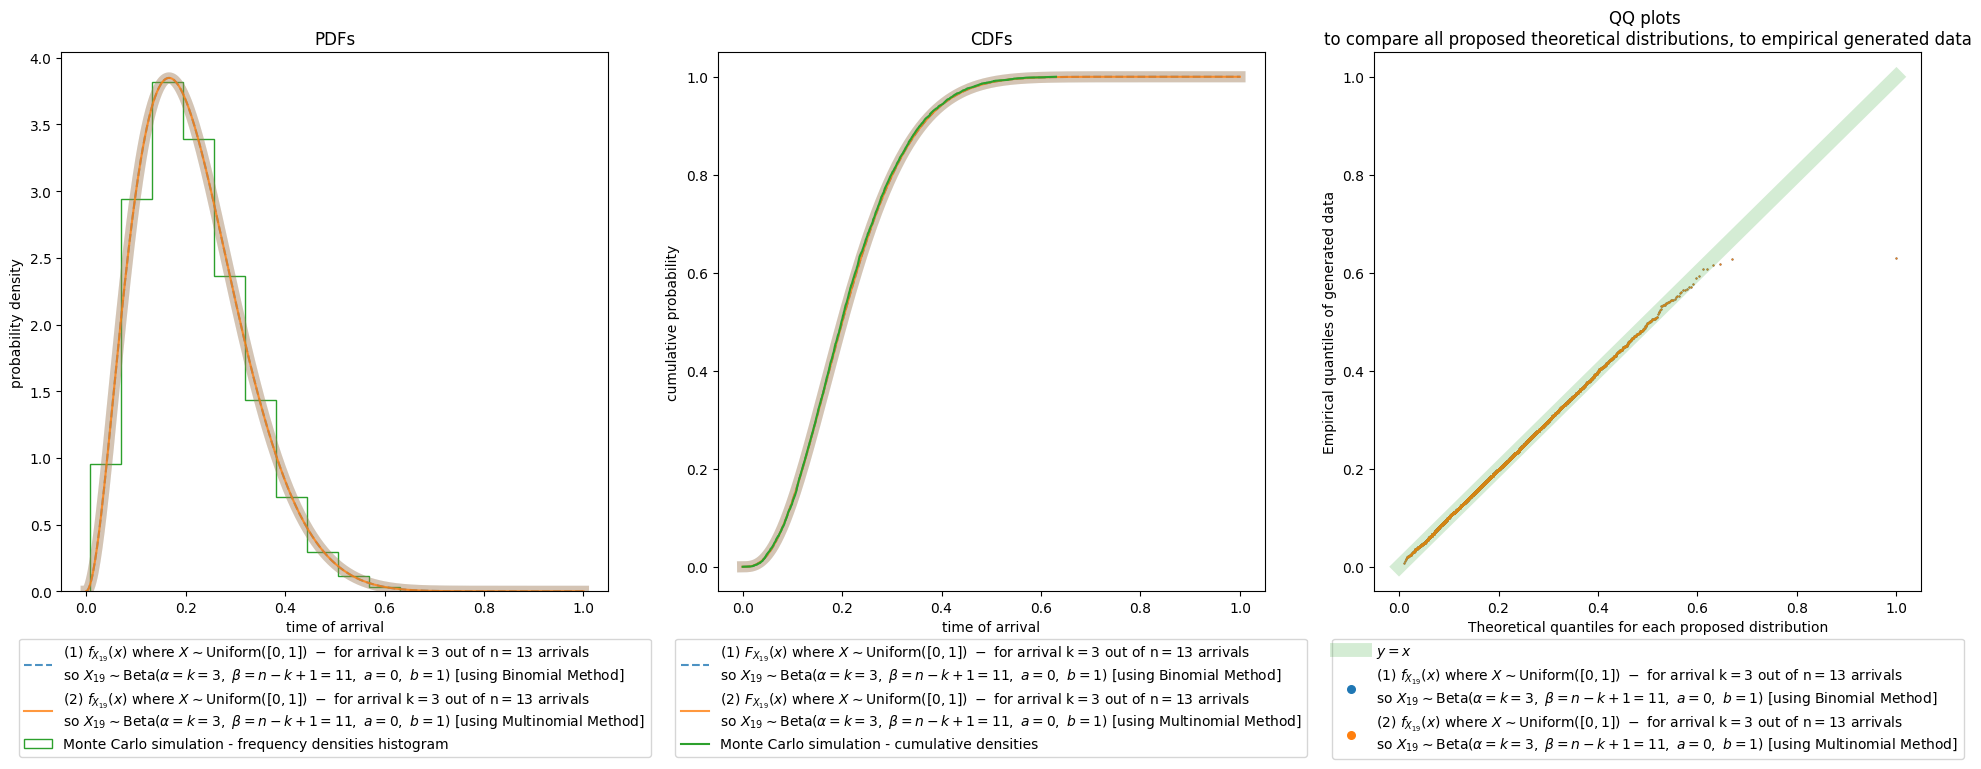

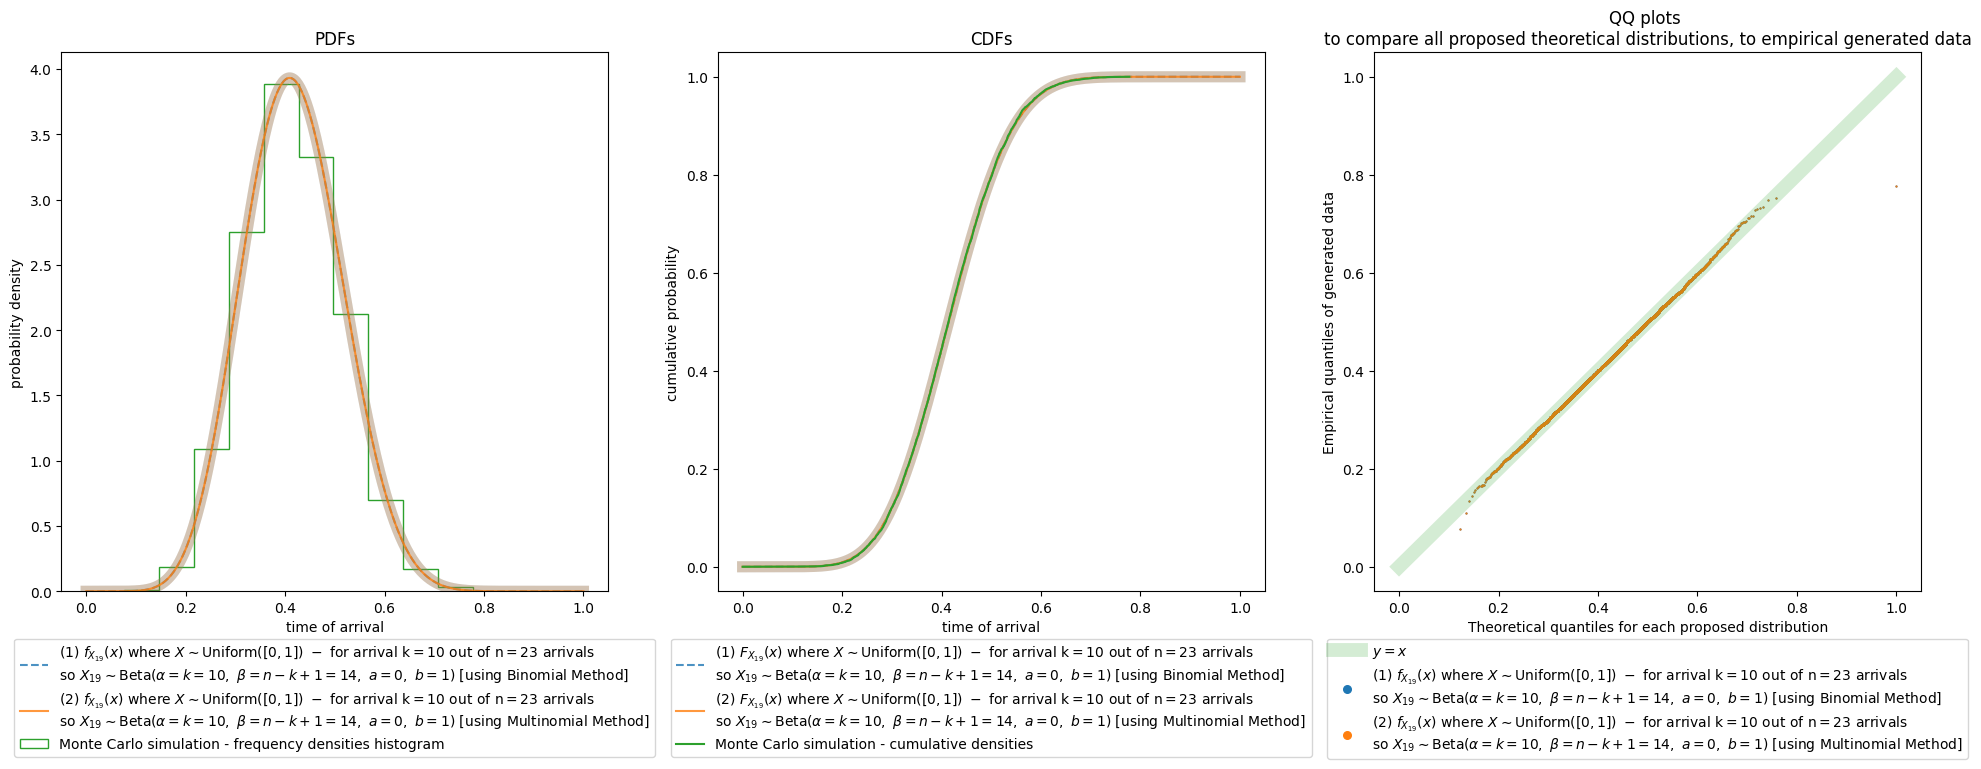

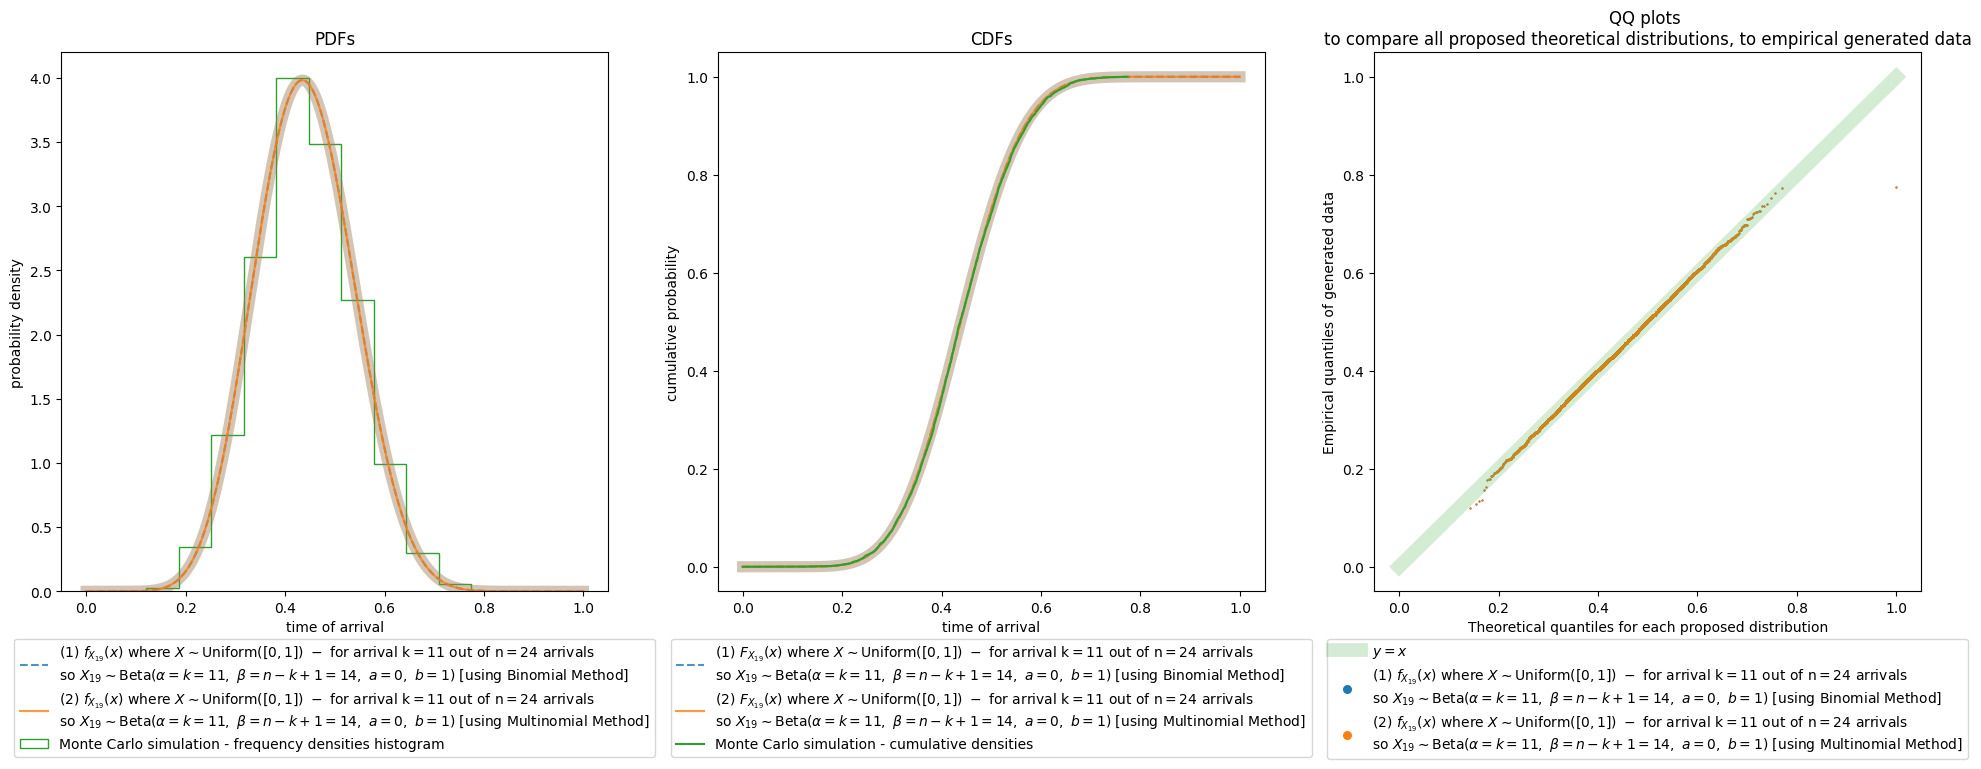

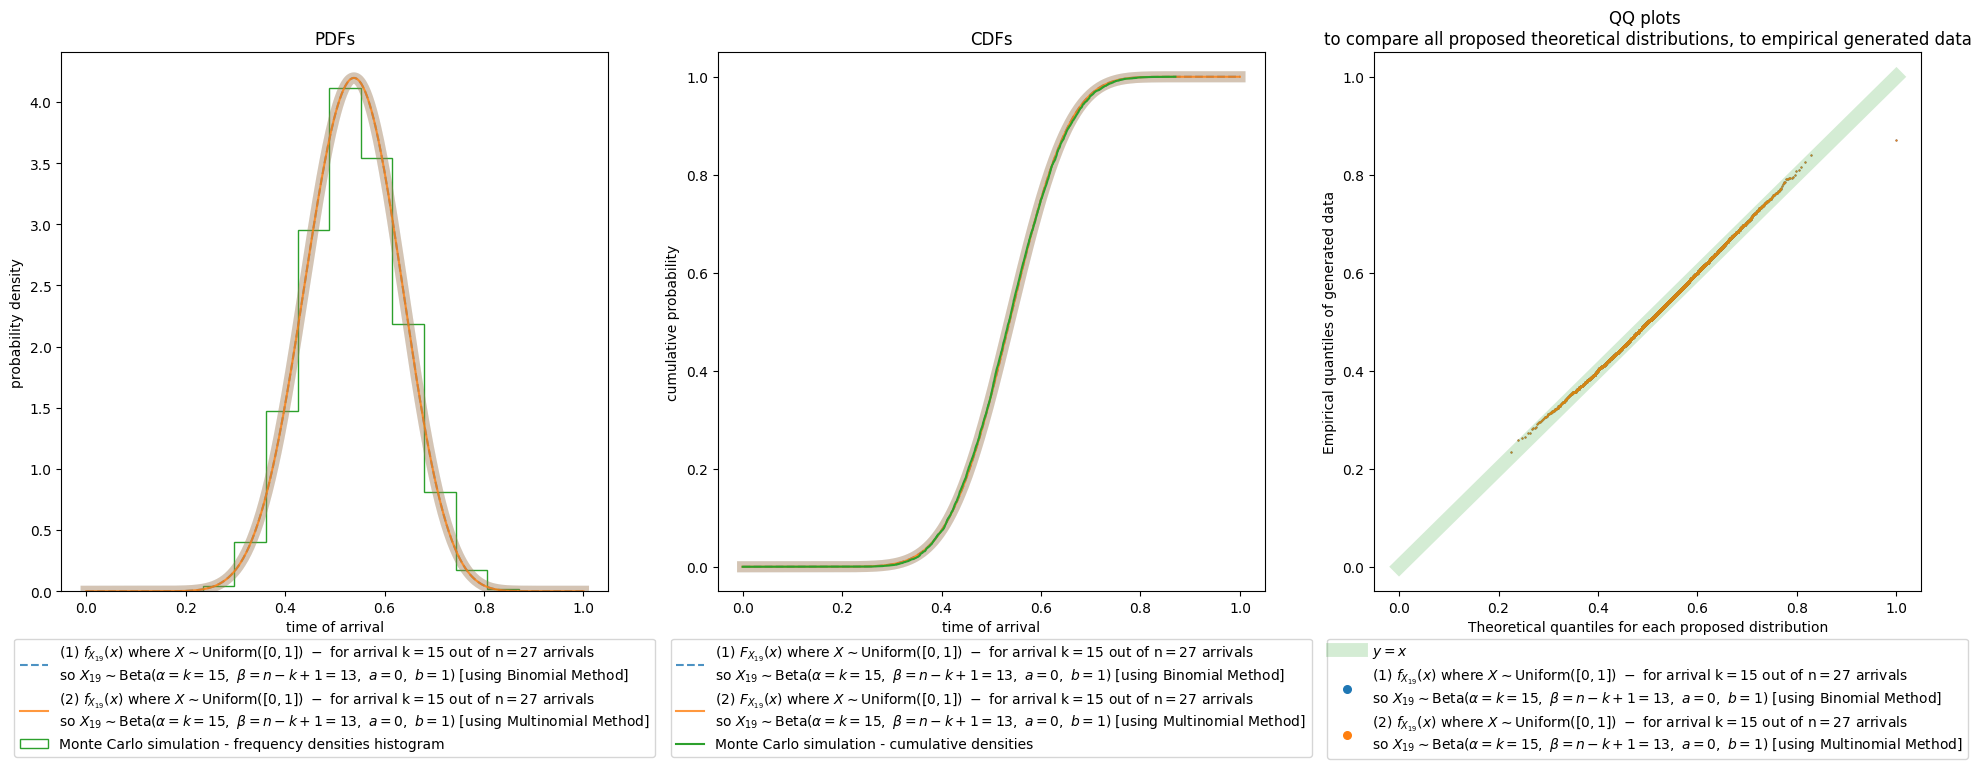

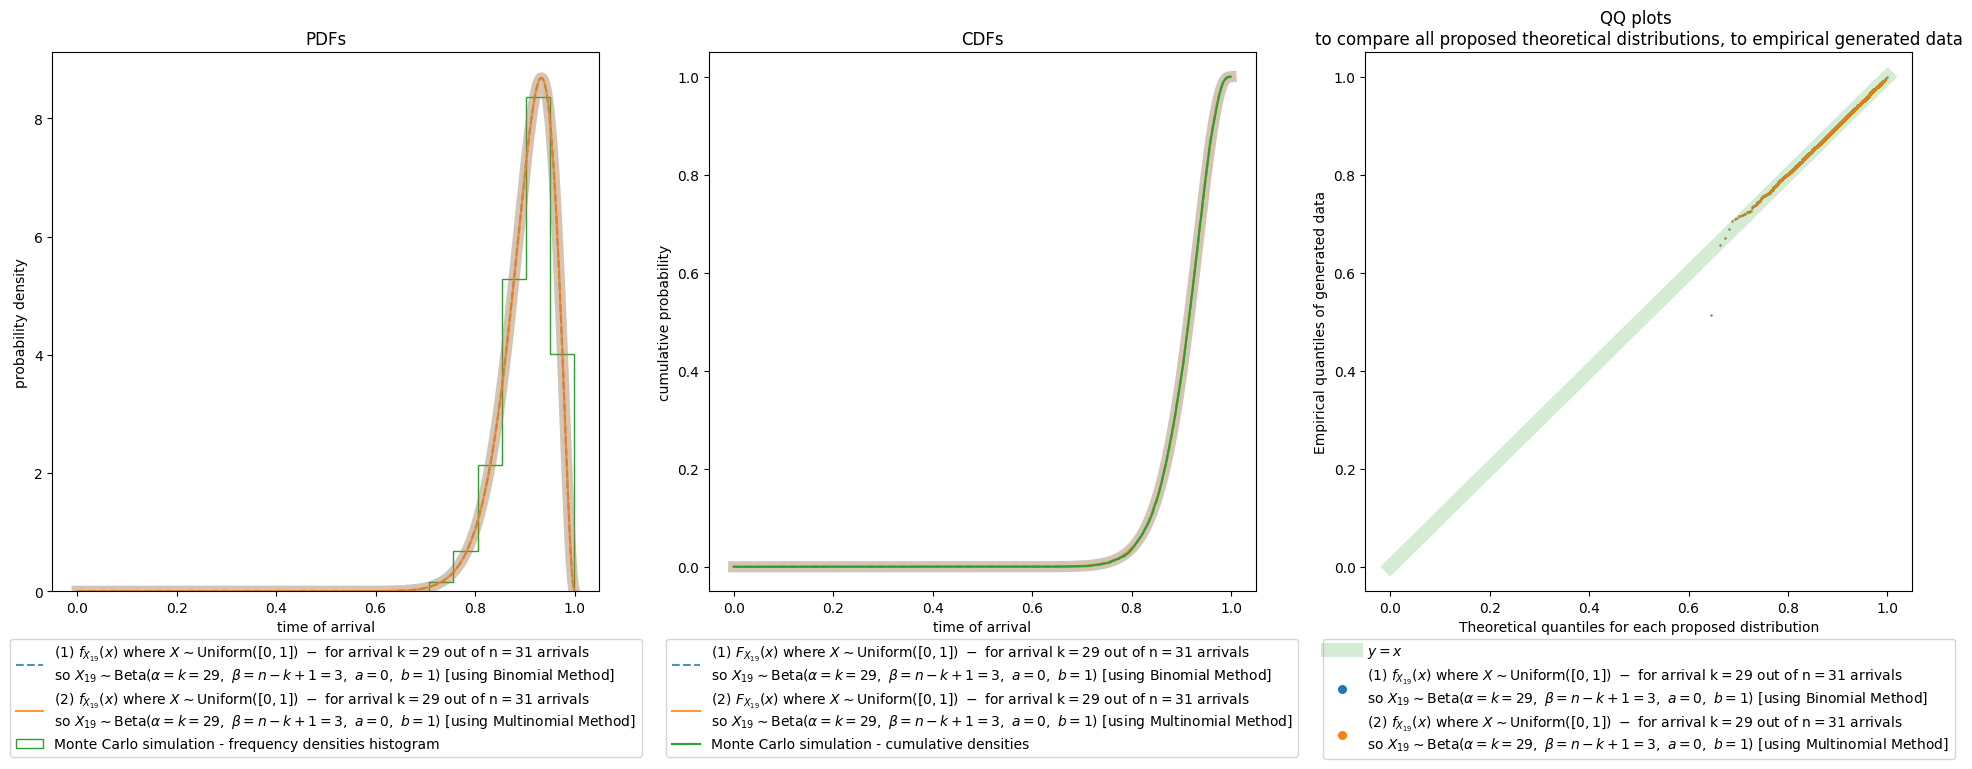

In [234]:
num_examples_to_plot = 5
sequence_length = 5000
a_start_time,b_end_time = 0,1

#choose n and k randomly
np.random.seed(1)           #this seed works nicely 
n_rand_selection = np.sort(np.random.choice(np.arange(10,35), size=num_examples_to_plot, replace=False))
k_rand_selection = (np.ceil(np.sort(np.random.uniform(0.,1, size=num_examples_to_plot)) * n_rand_selection)).astype(int)
# print(n_rand_selection, k_rand_selection)

for i in range(num_examples_to_plot):
    n_rand = n_rand_selection[i]
    k_rand = k_rand_selection[i]
    lambda_MLE_rand = n_rand / (b_end_time-a_start_time)
    lambda_rand = lambda_MLE_rand * (.75 + .5*np.random.random())
    poisson_samples_kth_arrival = generate_samples_k_of_n_poisson_arrivals_in_interval_ab(Lambda=lambda_rand, 
        k=k_rand, n=n_rand, a=a_start_time, b=b_end_time, 
        num_samples=sequence_length)

    list_PDFs_correct_only = [
        k_of_n_uniform_a_b_using_binomial   (a=a_start_time, b=b_end_time, n=n_rand, k=k_rand),
        k_of_n_uniform_a_b_using_multinomial(a=a_start_time, b=b_end_time, n=n_rand, k=k_rand),
    ]

    plot_multiple_PDFs_CDFs_QQs(list_PDFs_correct_only, empirical_data=poisson_samples_kth_arrival, support_subset=[a_start_time, b_end_time])
